# прогнозирование поле нефтенасыщенности в зонах высокой неопределенности

внутри этого ноутбука собраны все этапы от чтения сырых данных до тренировки диффузионной модели.

## подготовка окружения

In [19]:
from __future__ import annotations

import os
import math
from datetime import datetime
from pathlib import Path
from typing import Iterable, Tuple

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Dataset

# устанавливаем utf-8 на уровне процесса
os.environ["PYTHONIOENCODING"] = "utf-8"


## подготовка данных и наборов

здесь описаны функции для преобразования petrel (spe9) и tnavigator, генерации карт насыщенности и формирования pytorch-датасета.

In [20]:
# блок обработки данных и наборов

GDM_LAYERS = 50
GDM_HEIGHT = 50
GDM_WIDTH = 50
GDM_TOTAL_CELLS = GDM_LAYERS * GDM_HEIGHT * GDM_WIDTH
GDM_STATIC_FIELDS = [
    ("dx", "DX"),
    ("dy", "DY"),
    ("dz", "DZ"),
    ("permx", "INIT_PERMX"),
    ("permy", "INIT_PERMY"),
    ("permz", "INIT_PERMZ"),
    ("poro", "INIT_PORO"),
]


def _read_lines(path: Path) -> list[str]:
    """читаем файл и нормализуем null байты из spe9."""
    text = path.read_bytes().decode("latin-1")
    return [line for line in text.replace("\x00", "").splitlines()]


def parse_dimensions(path: Path) -> Tuple[int, int, int]:
    """находим параметры сетки (i, j, k) по ключевому слову dimens."""
    lines = _read_lines(path)
    for idx, line in enumerate(lines):
        token = line.strip()
        if token.startswith("DIMENS"):
            for next_line in lines[idx + 1 :]:
                next_token = next_line.strip()
                if not next_token or next_token.startswith("--"):
                    continue
                numbers = next_token.replace("/", "").split()
                if len(numbers) >= 3:
                    return tuple(int(tok) for tok in numbers[:3])
    raise ValueError("Could not parse DIMENS from SPE9 file.")


def parse_perm_values(path: Path, dims: Tuple[int, int, int]) -> np.ndarray:
    """разбираем блок permx и возвращаем проницаемости (k, j, i)."""
    lines = _read_lines(path)
    i_dim, j_dim, k_dim = dims
    values: list[float] = []
    in_perm = False
    for line in lines:
        token = line.strip()
        if not token:
            continue
        if token.startswith("PERMX"):
            in_perm = True
            continue
        if "PERMY" in token:
            break
        if not in_perm:
            continue
        if token.startswith("--") or token.startswith("LAYER") or token.startswith("ROW"):
            continue
        values.extend(
            float(val)
            for val in token.split()
            if val not in {"/", ""}
        )
        if len(values) >= i_dim * j_dim * k_dim:
            break
    expected = i_dim * j_dim * k_dim
    if len(values) < expected:
        raise ValueError(
            f"PERMX data contains only {len(values)} entries, expected {expected}."
        )
    arr = np.array(values[:expected], dtype=np.float32)
    perm = arr.reshape(k_dim, j_dim, i_dim)
    return perm


def parse_porosity(path: Path) -> np.ndarray:
    """считываем блок poro с одним значением на слой."""
    lines = _read_lines(path)
    poros = []
    in_poro = False
    for line in lines:
        token = line.strip()
        if not token:
            continue
        if token.startswith("PORO"):
            in_poro = True
            continue
        if in_poro:
            if token.startswith("--"):
                continue
            entries = token.split()
            for entry in entries:
                if entry == "/":
                    return np.array(poros, dtype=np.float32)
                if "*" in entry:
                    _, value = entry.split("*", 1)
                    poros.append(float(value))
                else:
                    try:
                        poros.append(float(entry))
                    except ValueError:
                        continue
    return np.array(poros, dtype=np.float32)


def parse_injector_location(path: Path) -> Tuple[int, int]:
    """находим координаты инжектора (i, j) в комвдате."""
    lines = _read_lines(path)
    in_compdat = False
    for line in lines:
        token = line.strip()
        if token.startswith("COMPDAT"):
            in_compdat = True
            continue
        if not in_compdat:
            continue
        if not token or token.startswith("--"):
            continue
        parts = token.replace("'", "").split()
        if parts and parts[0].startswith("INJE"):
            i = int(parts[1]) - 1
            j = int(parts[2]) - 1
            return i, j
    raise ValueError("Injector not found in COMPDAT.")


def generate_saturation_series(
    perm: np.ndarray,
    porosity: np.ndarray,
    injector: Tuple[int, int],
    times: Iterable[float],
    rng: np.random.Generator | None = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """генерируем карты насыщенности по геометрии spe9."""
    if rng is None:
        rng = np.random.default_rng(42)

    layers, rows, cols = perm.shape
    if porosity.shape[0] != layers:
        raise ValueError("Porosity vector length must match number of layers.")

    # нормализуем perm к диапазону [0, 1]
    perm_norm = (perm - perm.min()) / (perm.max() - perm.min() + 1e-8)
    ii, jj = np.meshgrid(np.arange(cols), np.arange(rows), indexing="xy")
    inj_i, inj_j = injector
    distance = np.sqrt((ii - inj_i) ** 2 + (jj - inj_j) ** 2)
    max_dist = float(distance.max())
    if max_dist <= 0:
        max_dist = 1.0
    distance_norm = distance / max_dist

    layer_bias = 1.0 - 0.3 * (np.arange(layers) / max(1, layers - 1))
    layer_bias = layer_bias[:, None, None]

    times_array = np.array(list(times), dtype=np.float32)
    sat = np.zeros((len(times_array), layers, rows, cols), dtype=np.float32)
    tau_base = 0.2

    for idx, t in enumerate(times_array):
        front = t * max_dist * 1.2
        sigma = max_dist * 0.08 + 1e-6
        progress = 0.5 * (np.tanh((front - distance) / sigma) + 1.0)
        progress = np.clip(progress, 0.0, 1.0)
        tau = tau_base * (1.0 + distance_norm)[None, ...] * (1.0 + (1.0 - perm_norm)) * (
            1.0 + 0.4 * (np.arange(layers)[:, None, None] / max(1, layers - 1))
        )
        timing = 1.0 - np.exp(-t / (tau + 1e-6))
        prefactor = 0.6 + 0.4 * perm_norm
        swc = 0.15
        target_range = 0.9 - swc
        base = swc + target_range * progress[None, ...] * layer_bias * timing * prefactor
        noise = rng.normal(scale=0.003, size=base.shape).astype(np.float32)
        sat_map = np.clip(base + noise, swc, 0.93)
        sat[idx] = sat_map
    return sat, distance_norm.astype(np.float32)


def build_spe_dataset(
    raw_dir: Path,
    output_path: Path,
    times: Iterable[float] | None = None,
) -> Path:
    """создаем сжатый датасет для тренировки диффузии в colab."""
    raw_dir = raw_dir.expanduser()
    perm_path = raw_dir / "PERMVALUES.DATA"
    deck_path = raw_dir / "SPE9.DATA"
    if not perm_path.exists() or not deck_path.exists():
        raise FileNotFoundError(f"Raw SPE9 files were not found in {raw_dir}.")

    dims = parse_dimensions(deck_path)
    perm = parse_perm_values(perm_path, dims)
    porosity = parse_porosity(deck_path)
    injector = parse_injector_location(deck_path)
    if times is None:
        times = np.linspace(0.02, 1.0, 32)

    saturations, distance = generate_saturation_series(
        perm, porosity, injector, times
    )
    np.savez_compressed(
        output_path,
        saturations=saturations,
        perm_norm=(perm - perm.min()) / (perm.max() - perm.min() + 1e-8),
        porosity=porosity,
        distance=distance,
        times=np.array(list(times), dtype=np.float32),
    )
    return output_path


def _parse_gdm_block(path: Path, keyword: str) -> np.ndarray:
    text = path.read_text(encoding="latin-1")
    tokens: list[str] = []
    collecting = False
    for part in text.split():
        if not collecting:
            if part == keyword:
                collecting = True
            continue
        if part == "/":
            break
        if part.startswith("--"):
            continue
        tokens.append(part)

    values: list[float] = []
    for token in tokens:
        if "*" in token:
            count_str, value_str = token.split("*", 1)
            count = int(float(count_str))
            value = float(value_str)
            values.extend([value] * count)
        else:
            values.append(float(token))

    arr = np.array(values, dtype=np.float32)
    if arr.size != GDM_TOTAL_CELLS:
        raise ValueError(
            f"{path.name} contains {arr.size} entries but expected {GDM_TOTAL_CELLS}."
        )
    arr[arr == 99999.0] = np.nan
    return arr.reshape(GDM_LAYERS, GDM_HEIGHT, GDM_WIDTH)


def _collect_gdm_dates(raw_dir: Path) -> list[tuple[datetime, Path]]:
    entries: list[tuple[datetime, Path]] = []
    for candidate in raw_dir.iterdir():
        if not candidate.is_dir():
            continue
        try:
            parsed = datetime.strptime(candidate.name, "%d-%m-%Y")
        except ValueError:
            continue
        entries.append((parsed, candidate))
    if not entries:
        raise ValueError(f"No date folders found in {raw_dir}.")
    entries.sort(key=lambda pair: pair[0])
    return entries


def _normalize_gdm_times(dates: list[datetime]) -> np.ndarray:
    if len(dates) <= 1:
        return np.zeros(len(dates), dtype=np.float32)
    span = (dates[-1] - dates[0]).total_seconds()
    if span <= 0:
        return np.zeros(len(dates), dtype=np.float32)
    return np.array(
        [(date - dates[0]).total_seconds() / span for date in dates],
        dtype=np.float32,
    )


def build_gdm_dataset(raw_dir: Path, output_path: Path) -> Path:
    raw_dir = raw_dir.expanduser()
    if not raw_dir.exists():
        raise FileNotFoundError(f"GDM directory {raw_dir} was not found.")
    dated_entries = _collect_gdm_dates(raw_dir)

    saturations = np.empty(
        (len(dated_entries), GDM_LAYERS, GDM_HEIGHT, GDM_WIDTH), dtype=np.float32
    )
    date_objs: list[datetime] = []
    for idx, (date_obj, folder) in enumerate(dated_entries):
        soil_path = folder / "SOIL.txt"
        if not soil_path.exists():
            raise FileNotFoundError(f"SOIL.txt missing from {folder}")
        saturations[idx] = _parse_gdm_block(soil_path, "SOIL")
        date_objs.append(date_obj)

    static_source = dated_entries[0][1]
    static_data = {
        key: _parse_gdm_block(static_source / f"{label}.txt", label)
        for key, label in GDM_STATIC_FIELDS
    }
    actnum = _parse_gdm_block(static_source / "ACTNUM.txt", "ACTNUM")
    mask = np.nan_to_num(actnum, nan=0.0)
    mask = np.where(mask == 1.0, 1.0, 0.0).astype(np.float32)

    times = _normalize_gdm_times(date_objs)
    date_strings = np.array(
        [dt.strftime("%Y-%m-%d") for dt in date_objs], dtype=np.str_
    )

    output_path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        output_path,
        saturations=saturations,
        dx=static_data["dx"],
        dy=static_data["dy"],
        dz=static_data["dz"],
        permx=static_data["permx"],
        permy=static_data["permy"],
        permz=static_data["permz"],
        poro=static_data["poro"],
        actnum_mask=mask,
        times=times,
        date_strings=date_strings,
    )
    return output_path


class SPE9SaturationDataset(torch.utils.data.Dataset):
    """набор данных pytorch возвращает карту условий и целевое поле насыщенности."""

    def __init__(self, data_path: Path):
        data = np.load(data_path)
        self.saturations = data["saturations"]
        self.perm = data["perm_norm"]
        self.porosity = data["porosity"]
        self.distance = data["distance"]
        self.times = data["times"]
        self.height, self.width = self.perm.shape[1:]
        self.layers = self.perm.shape[0]
        self.target_channels = self.layers
        self.cond_channels = self.layers * 2 + 2

    def __len__(self) -> int:
        return self.saturations.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        target = torch.from_numpy(self.saturations[idx])
        cond = self._build_condition(idx)
        return cond, target

    def _build_condition(self, idx: int) -> torch.FloatTensor:
        time_value = float(self.times[idx])
        time_channel = np.full(
            (1, self.height, self.width), time_value, dtype=np.float32
        )
        poro_tile = self.porosity[:, None, None] * np.ones(
            (1, self.height, self.width), dtype=np.float32
        )
        cond = np.concatenate(
            [
                self.perm,
                poro_tile,
                self.distance[None],
                time_channel,
            ],
            axis=0,
        )
        return torch.from_numpy(cond.astype(np.float32))


class GDMStateDataset(torch.utils.data.Dataset):
    """загружаем экспорт tnavigator и возвращаем насыщенности с статическими полями."""

    def __init__(self, data_path: Path):
        data = np.load(data_path)
        self.saturations = data["saturations"]
        self.dx = data["dx"]
        self.dy = data["dy"]
        self.dz = data["dz"]
        self.permx = data["permx"]
        self.permy = data["permy"]
        self.permz = data["permz"]
        self.poro = data["poro"]
        self.mask = data["actnum_mask"]
        self.times = data["times"]
        self.date_strings = data["date_strings"]
        self.layers = self.saturations.shape[1]
        self.height = self.saturations.shape[2]
        self.width = self.saturations.shape[3]

        static_features = [
            self.dx,
            self.dy,
            self.dz,
            self.permx,
            self.permy,
            self.permz,
            self.poro,
            self.mask,
        ]
        cond_stack = np.concatenate(
            [np.nan_to_num(feature, nan=0.0) for feature in static_features], axis=0
        )
        self.cond_static = cond_stack.astype(np.float32)
        self.target_channels = self.layers
        self.cond_channels = self.cond_static.shape[0] + 1

    def __len__(self) -> int:
        return self.saturations.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        target = np.nan_to_num(self.saturations[idx], nan=0.0).astype(np.float32)
        cond = self._build_condition(idx)
        return cond, torch.from_numpy(target)

    def _build_condition(self, idx: int) -> torch.FloatTensor:
        time_value = float(self.times[idx])
        time_channel = np.full(
            (1, self.height, self.width), time_value, dtype=np.float32
        )
        cond = np.concatenate([self.cond_static, time_channel], axis=0)
        return torch.from_numpy(cond)



# =========================
# УТИЛИТЫ ДЛЯ УСЛОВИЙ (delta/z)
# =========================
def _fourier_features_scalar(x: float, n_freq: int = 8, include_scalar: bool = True) -> np.ndarray:
    """
    Детерминированный "эмбеддинг" скаляра x (обычно 0..1) через Fourier features.
    Плюс в том, что можно выходить за диапазон обучения мягче, чем с one-hot.
    """
    x = float(x)
    feats: list[float] = []
    if include_scalar:
        feats.append(x)
    # экспоненциальная шкала частот
    freqs = (2.0 ** np.arange(n_freq, dtype=np.float32)) * np.pi
    for f in freqs:
        feats.append(float(np.sin(f * x)))
        feats.append(float(np.cos(f * x)))
    return np.asarray(feats, dtype=np.float32)


def encode_scalar_channel(
    x: float,
    *,
    encoding: str = "embed",
    n_freq: int = 8,
    onehot_size: int | None = None,
    onehot_kind: str = "z",  # "z" | "delta"
    max_delta_steps: int | None = None,
) -> np.ndarray:
    """Единый энкодер скаляра для условий (delta/z), чтобы можно было быстро переключаться.

    encoding:
      - "scalar": один канал [x]
      - "embed": Fourier-features (детерминированный эмбеддинг)
      - "onehot": one-hot вектор заданной длины

    Для delta one-hot ожидаем, что x = delta_norm = k/max_delta_steps (k>=1), а индекс = k-1.
    Для z one-hot ожидаем, что x = z_norm in [0,1], а индекс = round(x*(layers-1)).
    """
    x = float(x)

    if encoding == "scalar":
        return np.asarray([x], dtype=np.float32)

    if encoding == "embed":
        return _fourier_features_scalar(x, n_freq=int(n_freq), include_scalar=True)

    if encoding == "onehot":
        if onehot_size is None:
            raise ValueError("onehot_size обязателен для onehot-кодировки.")
        size = int(onehot_size)
        vec = np.zeros((size,), dtype=np.float32)

        if onehot_kind == "delta":
            mds = int(max_delta_steps) if max_delta_steps is not None else size
            # x = k/mds -> k = round(x*mds) в [1..mds]
            kk = int(np.clip(np.rint(x * mds), 1, mds))
            idx = kk - 1
        else:
            # z: idx = round(x*(size-1))
            idx = int(np.clip(np.rint(x * (size - 1)), 0, size - 1))

        if 0 <= idx < size:
            vec[idx] = 1.0
        return vec

    raise ValueError(f"Неизвестная кодировка: {encoding}")

def _encode_delta(
    delta_norm: float,
    k: int,
    *,
    delta_mode: str,
    max_delta_steps: int,
    encoding: str = "embed",   # "scalar" | "onehot" | "embed"
    n_freq: int = 8,
) -> np.ndarray:
    """
    Возвращает вектор признаков delta (C,).
    - scalar: 1 канал
    - onehot: max_delta_steps каналов (только для delta_mode='index')
    - embed: Fourier-features (детерминированный эмбеддинг скаляра delta_norm)
    """
    if encoding == "scalar":
        return np.asarray([float(delta_norm)], dtype=np.float32)

    if encoding == "onehot":
        if delta_mode != "index":
            raise ValueError("onehot для delta разрешен только при delta_mode='index'.")
        vec = np.zeros((int(max_delta_steps),), dtype=np.float32)
        kk = int(k) - 1
        if 0 <= kk < vec.shape[0]:
            vec[kk] = 1.0
        return vec

    if encoding == "embed":
        return _fourier_features_scalar(delta_norm, n_freq=n_freq, include_scalar=True)

    raise ValueError(f"Неизвестное delta_encoding={encoding}")

def _encode_z(
    z_norm: float,
    z_index: int,
    *,
    layers: int,
    encoding: str = "embed",  # "scalar" | "onehot" | "embed"
    n_freq: int = 4,
) -> np.ndarray:
    """
    Возвращает вектор признаков слоя (C,).
    - scalar: 1 канал (как раньше, но слабовато)
    - onehot: layers каналов
    - embed: Fourier-features по z_norm
    """
    if encoding == "scalar":
        return np.asarray([float(z_norm)], dtype=np.float32)

    if encoding == "onehot":
        vec = np.zeros((int(layers),), dtype=np.float32)
        zz = int(z_index)
        if 0 <= zz < vec.shape[0]:
            vec[zz] = 1.0
        return vec

    if encoding == "embed":
        return _fourier_features_scalar(z_norm, n_freq=n_freq, include_scalar=True)

    raise ValueError(f"Неизвестное z_encoding={encoding}")

def build_cond_numpy(
    *,
    mask: np.ndarray,           # (H,W) 0/1
    base01: np.ndarray,         # (H,W) 0..1 (или 0 в неактиве)
    delta_norm: float,
    k: int,
    z_index: int,
    layers: int,
    delta_mode: str,
    max_delta_steps: int,
    delta_encoding: str,
    z_encoding: str,
    delta_freqs: int,
    z_freqs: int,
) -> np.ndarray:
    """
    Сборка cond в одном месте, чтобы train и inference были консистентны.
    Возвращает cond (C,H,W).
    """
    H, W = base01.shape
    base_n = base01 * 2.0 - 1.0

    z_norm = 0.0 if layers <= 1 else float(z_index) / float(layers - 1)

    delta_vec = _encode_delta(
        delta_norm, k,
        delta_mode=delta_mode,
        max_delta_steps=max_delta_steps,
        encoding=delta_encoding,
        n_freq=delta_freqs,
    )
    z_vec = _encode_z(
        z_norm, z_index,
        layers=layers,
        encoding=z_encoding,
        n_freq=z_freqs,
    )

    # broadcast (C,1,1) -> (C,H,W)
    delta_maps = np.repeat(delta_vec[:, None, None], H, axis=1)
    delta_maps = np.repeat(delta_maps, W, axis=2)

    z_maps = np.repeat(z_vec[:, None, None], H, axis=1)
    z_maps = np.repeat(z_maps, W, axis=2)

    def _as_chw(arr: np.ndarray) -> np.ndarray:
        arr = np.asarray(arr)
        if arr.ndim == 2:      # (H,W) -> (1,H,W)
            return arr[None, ...]
        if arr.ndim == 3:      # уже (C,H,W)
            return arr
        raise ValueError(f"Expected 2D or 3D array, got shape {arr.shape}")

    mask_chw = _as_chw(mask).astype(np.float32)
    base_chw = _as_chw(base_n).astype(np.float32)

    cond = np.concatenate(
        [
            mask_chw,
            base_chw,
            delta_maps.astype(np.float32),
            z_maps.astype(np.float32),
        ],
        axis=0,
    )
    return cond


def estimate_ds_clip_from_pairs(
    data_path: Path,
    *,
    base_times: Iterable[int],
    target_times: Iterable[int] | None,
    max_delta_steps: int,
    delta_mode: str,
    quantile: float = 0.99,
) -> float:
    """
    Оценка масштаба |ΔS| по train-парам. Рекомендуется использовать квантили (0.99).
    Возвращает dS_clip > 0.
    """
    data = np.load(data_path)
    sat_raw = data["saturations"]  # (T,Z,H,W) с NaN
    times = data.get("times")
    actnum = data.get("actnum_mask")
    if actnum is None:
        # fallback: активность по первому срезу
        actnum = np.isfinite(sat_raw[0, 0])
    actnum = actnum.astype(bool)

    T = sat_raw.shape[0]
    base_set = set(int(x) for x in base_times)
    target_set = set(int(x) for x in target_times) if target_times is not None else None

    chunks = []
    for t in range(T - 1):
        if t not in base_set:
            continue
        max_k_here = min(int(max_delta_steps), T - 1 - t)
        base = sat_raw[t]      # (Z,H,W)
        base_ok = np.isfinite(base)
        for k in range(1, max_k_here + 1):
            t2 = t + k
            if target_set is not None and t2 not in target_set:
                continue
            if delta_mode == "time":
                if times is None:
                    continue
                dt = float(times[t2] - times[t])
                if dt <= 0:
                    continue
            targ = sat_raw[t2]
            targ_ok = np.isfinite(targ)
            act = actnum
            if act.ndim == 2 and base.ndim == 3:
                act = np.broadcast_to(act[None, ...], base.shape)  # (Z,H,W)

            mask_pair = act & base_ok & targ_ok
            ds = np.abs(targ - base)[mask_pair]
            if ds.size:
                chunks.append(ds.astype(np.float32))
    if not chunks:
        # безопасный fallback
        return 0.1
    all_ds = np.concatenate(chunks, axis=0)
    q = float(np.quantile(all_ds, quantile))
    return max(q, 1e-6)

# =========================
# ДАТАСЕТ: слои как примеры + мультишаг + ΔS
# =========================
class GDMForecastDataset(torch.utils.data.Dataset):
    """
    Прогноз по временным картам насыщенности в постановке 'по слоям' и через приращение ΔS.

    Из исходного 4D массива (T, Z, H, W) формируем много обучающих примеров:
      base = S[t, z]
      target = ΔS = S[t+k, z] - S[t, z]

    Условие (cond) минимальное и контролируемое, но с гибкой кодировкой delta и z:
      [mask, base_norm, delta_encoding(...), z_encoding(...)]
    """

    def __init__(
        self,
        data_path: Path,
        delta_mode: str = "index",
        max_delta_steps: int | None = None,
        dS_clip: float = 0.1,
        base_times: Iterable[int] | None = None,
        target_times: Iterable[int] | None = None,
        delta_encoding: str = "embed",    # "scalar" | "onehot" | "embed"
        z_encoding: str = "embed",        # "scalar" | "onehot" | "embed"
        delta_freqs: int = 8,
        z_freqs: int = 4,
    ):
        data = np.load(data_path)
        self.sat_raw = data["saturations"]     # (T,Z,H,W) с NaN
        self.saturations = np.nan_to_num(self.sat_raw, nan=0.0).astype(np.float32)
        self.actnum_mask = data.get("actnum_mask")
        if self.actnum_mask is None:
            self.actnum_mask = np.isfinite(self.sat_raw[0, 0])
        self.actnum_mask = self.actnum_mask.astype(bool)

        self.times = data.get("times")
        self.date_strings = data.get("date_strings", None)

        self.total_steps = self.saturations.shape[0]
        self.layers = self.saturations.shape[1]
        self.height = self.saturations.shape[2]
        self.width = self.saturations.shape[3]

        self.delta_mode = str(delta_mode)
        self.max_delta_steps = int(max_delta_steps if max_delta_steps is not None else (self.total_steps - 1))
        self.max_delta_steps = int(min(self.max_delta_steps, self.total_steps - 1))
        self.dS_clip = float(dS_clip)

        self.delta_encoding = str(delta_encoding)
        self.z_encoding = str(z_encoding)
        self.delta_freqs = int(delta_freqs)
        self.z_freqs = int(z_freqs)

        if self.delta_mode not in {"time", "index"}:
            raise ValueError("delta_mode должен быть 'time' или 'index'.")

        # средний dt (для авто горизонта)
        self.mean_time_delta = 0.0
        if self.delta_mode == "time" and self.times is not None and len(self.times) >= 2:
            diffs = np.diff(self.times.astype(np.float32))
            diffs = diffs[diffs > 0]
            self.mean_time_delta = float(np.mean(diffs)) if diffs.size else 0.0

        # ограничения по времени для пары (base -> target)
        if base_times is None:
            base_set = set(range(self.total_steps - 1))
        else:
            base_set = set(int(x) for x in base_times)
        target_set = set(int(x) for x in target_times) if target_times is not None else None

        # список примеров: (t, z, k, delta, t2)
        self.samples: list[tuple[int, int, int, float, int]] = []
        for t in range(self.total_steps - 1):
            if t not in base_set:
                continue
            max_k_here = min(self.max_delta_steps, self.total_steps - 1 - t)
            for k in range(1, max_k_here + 1):
                t2 = t + k
                if target_set is not None and t2 not in target_set:
                    continue
                if self.delta_mode == "index":
                    delta = float(k)
                else:
                    if self.times is None:
                        continue
                    delta = float(self.times[t2] - self.times[t])
                if delta <= 0.0:
                    continue
                for z in range(self.layers):
                    self.samples.append((t, z, k, delta, t2))
        if not self.samples:
            raise ValueError("Недостаточно пар (t->t+k) после фильтрации по времени.")

        # каналы
        self.target_channels = 1  # ΔS для одного слоя
        # [mask(1) + base(1) + delta(Cd) + z(Cz)]
        dummy_delta = _encode_delta(0.0, 1, delta_mode=self.delta_mode, max_delta_steps=self.max_delta_steps,
                                   encoding=self.delta_encoding, n_freq=self.delta_freqs)
        dummy_z = _encode_z(0.0, 0, layers=self.layers, encoding=self.z_encoding, n_freq=self.z_freqs)
        self.cond_channels = 2 + int(dummy_delta.shape[0]) + int(dummy_z.shape[0])

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        t, z, k, delta, t2 = self.samples[idx]

        base = self.saturations[t, z]   # (H,W) 0..1
        targ = self.saturations[t2, z]  # (H,W) 0..1

        # маска пары: actnum & finite(base) & finite(target)
        base_ok = np.isfinite(self.sat_raw[t, z])
        targ_ok = np.isfinite(self.sat_raw[t2, z])

        act = self.actnum_mask
        if getattr(act, "ndim", 0) == 3:
            act = act[z]  # берем маску ТОЛЬКО текущего слоя (H,W)

        mask = (act & base_ok & targ_ok).astype(np.float32)


        # ΔS и нормализация
        dS = (targ - base).astype(np.float32)
        dS_n = np.clip(dS / self.dS_clip, -1.0, 1.0).astype(np.float32)

        # delta_norm
        if self.delta_mode == "index":
            delta_norm = float(k) / float(max(1, self.max_delta_steps))
        else:
            total = float(self.times[-1] - self.times[0]) if self.times is not None else 1.0
            delta_norm = float(delta) / total if total > 0 else 0.0

        cond = build_cond_numpy(
            mask=mask,
            base01=base,
            delta_norm=delta_norm,
            k=k,
            z_index=z,
            layers=self.layers,
            delta_mode=self.delta_mode,
            max_delta_steps=self.max_delta_steps,
            delta_encoding=self.delta_encoding,
            z_encoding=self.z_encoding,
            delta_freqs=self.delta_freqs,
            z_freqs=self.z_freqs,
        )

        target = dS_n[None, ...].astype(np.float32)
        mask_t = mask[None, ...].astype(np.float32)

        return torch.from_numpy(cond), torch.from_numpy(target), torch.from_numpy(mask_t)


## конфигурация обучения

задаем словарь nastroiki прямо внутри ноутбука, чтобы гибко менять параметры.

In [21]:
DS_CLIP = 0.1  # fallback, если не включена авто-оценка масштаба ΔS
# описываем настройки внутри ноутбука
config = {
    "data": {
        "source": "gdm",
        "path": "gdm_saturation.npz",
        "mode": "forecast",
        # 'index' = k/max_delta_steps; 'time' = нормированный Δt
        "delta_mode": "index",
        "max_delta_steps": 8,
        "layers": 50,

        # кодировки условий
        # delta_encoding: "scalar" | "onehot" | "embed" (Fourier-features)
        "delta_encoding": "embed",
        "delta_freqs": 8,
        # z_encoding: "scalar" | "onehot" | "embed"
        "z_encoding": "embed",
        "z_freqs": 4,

        # масштаб ΔS:
        # - float: фиксированный (как раньше)
        # - "auto_q99": оценить по train (квантиль 0.99)
        "dS_clip": "auto_q99",

        # временной split (индексы t)
        # train: targets только внутри train, чтобы не "видеть будущее"
        "train_times": list(range(0, 6)),   # 0..5
        "val_times": [6, 7],
        "test_times": [8],
    },
    "train": {
        "epochs": 40,
        "batch_size": 32,
        "lr": 2e-4,
        "device": "auto",
        "num_workers": 0,
        "eval_every": 1,
        "checkpoint_dir": "checkpoints",
        "save_every": 1,

        # EMA (стабилизирует семплинг на малых датасетах)
        "use_ema": True,
        "ema_decay": 0.999
    },
    "diffusion": {
        "timesteps": 200,
        "beta_start": 1e-4,
        "beta_end": 0.02
    },
    "model": {
        "base_channels": 32
    }
}
print("прямо заданные параметры:", config)


прямо заданные параметры: {'data': {'source': 'gdm', 'path': 'gdm_saturation.npz', 'mode': 'forecast', 'delta_mode': 'index', 'max_delta_steps': 8, 'layers': 50, 'delta_encoding': 'embed', 'delta_freqs': 8, 'z_encoding': 'embed', 'z_freqs': 4, 'dS_clip': 'auto_q99', 'train_times': [0, 1, 2, 3, 4, 5], 'val_times': [6, 7], 'test_times': [8]}, 'train': {'epochs': 40, 'batch_size': 32, 'lr': 0.0002, 'device': 'auto', 'num_workers': 0, 'eval_every': 1, 'checkpoint_dir': 'checkpoints', 'save_every': 1, 'use_ema': True, 'ema_decay': 0.999}, 'diffusion': {'timesteps': 200, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model': {'base_channels': 32}}


## сбор и проверка датасетов

формируем npz файлы для gdm и spe9, затем проверяем структуру gdm архива.

In [22]:

# строим gdm насыщенности из tnavigator
gdm_source_path = Path("gdm/gdm")
gdm_output_path = Path(config["data"]["path"])
gdm_output_path.parent.mkdir(parents=True, exist_ok=True)
gdm_result_path = build_gdm_dataset(gdm_source_path, gdm_output_path)
print("gdm насыщенности сохранены в", gdm_result_path)

# обновляем spe9 npz при необходимости
spe9_raw_path = Path("data/raw")
spe9_output_path = Path("data/spe9_saturation.npz")
if not spe9_output_path.exists():
    build_spe_dataset(spe9_raw_path, spe9_output_path)
    print("spe9 npz создан в", spe9_output_path)
else:
    print("spe9 npz уже доступен в", spe9_output_path)


FileNotFoundError: GDM directory gdm/gdm was not found.

In [23]:

# смотрим содержимое gdm архива
with np.load(gdm_output_path) as archive:
    print("ключи архива:", archive.files)
    print("форма saturations:", archive["saturations"].shape)
    print("количество временных шагов:", archive["times"].shape)


ключи архива: ['saturations', 'dx', 'dy', 'dz', 'permx', 'permy', 'permz', 'poro', 'actnum_mask', 'times', 'date_strings']
форма saturations: (9, 50, 50, 50)
количество временных шагов: (9,)


## определение модели

вставляем внутри ноутбука классы unet и диффузии.

In [24]:
# блок модели диффузии

def timestep_embedding(timesteps: torch.Tensor, dim: int) -> torch.Tensor:
    """формируем синусоидальные эмбеддинги для шагов диффузии."""
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=timesteps.device)
        / max(1, half - 1)
    )
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2:
        emb = torch.cat([emb, torch.zeros((timesteps.shape[0], 1), device=timesteps.device)], dim=-1)
    return emb


class ConvBlock(nn.Module):
    """два слоя свертки с групповой нормализацией и нелинейностью."""

    def __init__(self, in_channels: int, out_channels: int, groups: int = 8):
        super().__init__()
        groups = min(groups, out_channels)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Down(nn.Module):
    """понижение разрешения и затем блок сверток."""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down = nn.Sequential(nn.MaxPool2d(2), ConvBlock(in_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down(x)


class Up(nn.Module):
    """повышение разрешения с объединением ветвей."""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class SimpleUNet(nn.Module):
    """компактный 2d unet объединяет условия с зашумленной целью."""

    def __init__(
        self,
        target_channels: int,
        cond_channels: int,
        base_channels: int = 64,
    ):
        super().__init__()
        input_channels = target_channels + cond_channels
        self.inc = ConvBlock(input_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.up1 = Up(base_channels * 4, base_channels * 2)
        self.up2 = Up(base_channels * 2, base_channels)
        self.outc = nn.Conv2d(base_channels, target_channels, kernel_size=1)
        emb_dim = base_channels
        self.time_embed = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 2),
            nn.SiLU(),
            nn.Linear(emb_dim * 2, emb_dim),
        )
        self.time_proj1 = nn.Linear(emb_dim, base_channels)
        self.time_proj2 = nn.Linear(emb_dim, base_channels * 2)
        self.time_proj3 = nn.Linear(emb_dim, base_channels * 4)

    def forward(self, x: torch.Tensor, cond: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = torch.cat([x, cond], dim=1)
        t_emb = self.time_embed(timestep_embedding(t, self.time_proj1.in_features))

        h1 = self.inc(x)
        h1 = h1 + self.time_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)
        d1 = self.down1(h1)
        d1 = d1 + self.time_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)
        d2 = self.down2(d1)
        d2 = d2 + self.time_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)
        u1 = self.up1(d2, d1)
        u2 = self.up2(u1, h1)
        return self.outc(u2)


class GaussianDiffusion(nn.Module):
    """процесс диффузии в стиле ddpm для очистки траекторий."""

    def __init__(
        self,
        model: nn.Module,
        timesteps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 0.02,
    ):
        super().__init__()
        self.model = model
        self.timesteps = timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))
        self.register_buffer(
            "sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod)
        )
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )
        posterior_variance = betas[1:]  * (1.0 - alphas_cumprod[:-1]) / (
            1.0 - alphas_cumprod[1:]
        )
        posterior_variance = torch.cat(
            [posterior_variance, torch.tensor([0.0], dtype=betas.dtype, device=betas.device)]
        )
        self.register_buffer("posterior_variance", posterior_variance)
        self.out_channels = model.outc.out_channels

    def _extract(self, arr: torch.Tensor, t: torch.Tensor, shape: tuple[int, ...]) -> torch.Tensor:
        out = arr.gather(-1, t).reshape(shape[0], *((1,) * (len(shape) - 1)))
        return out

    def q_sample(self, x_start: torch.Tensor, t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        sqrt_alpha_cumprod = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus * noise

    def p_losses(self, x_start: torch.Tensor, cond: torch.Tensor, mask: torch.Tensor | None = None) -> torch.Tensor:
        batch = x_start.shape[0]
        t = torch.randint(0, self.timesteps, (batch,), device=x_start.device)
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        predicted = self.model(x_noisy, cond, t)
        if mask is None:
            return F.mse_loss(predicted, noise)
        # mask: 1 for active cells, 0 for inactive (shape [B,1,H,W] or [B,C,H,W])
        if mask.shape[1] == 1 and predicted.shape[1] != 1:
            mask_eff = mask.repeat(1, predicted.shape[1], 1, 1)
        else:
            mask_eff = mask
        diff2 = (predicted - noise) ** 2
        return (diff2 * mask_eff).sum() / (mask_eff.sum() + 1e-6)

    def loss(self, x: torch.Tensor, cond: torch.Tensor, mask: torch.Tensor | None = None) -> torch.Tensor:
        return self.p_losses(x, cond, mask)

    def forward(self, x: torch.Tensor, cond: torch.Tensor, mask: torch.Tensor | None = None) -> torch.Tensor:
        return self.p_losses(x, cond, mask)

    def p_sample(self, x: torch.Tensor, cond: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        betas_t = self._extract(self.betas, t, x.shape)
        sqrt_recip_alphas = self._extract(self.sqrt_recip_alphas, t, x.shape)
        sqrt_one_minus = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        model_output = self.model(x, cond, t)
        model_mean = sqrt_recip_alphas * (
            x - betas_t * model_output / sqrt_one_minus
        )
        posterior_variance = self._extract(self.posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        nonzero_mask = (t != 0).float().reshape(
            x.shape[0], *((1,) * (x.dim() - 1))
        )
        return model_mean + nonzero_mask * torch.sqrt(posterior_variance) * noise

    @torch.no_grad()
    def sample(self, cond: torch.Tensor) -> torch.Tensor:
        batch_size = cond.shape[0]
        shape = (batch_size, self.out_channels, cond.shape[-2], cond.shape[-1])
        device = cond.device
        x = torch.randn(shape, device=device)
        for i in reversed(range(self.timesteps)):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            x = self.p_sample(x, cond, t)
        return x



# =========================
# EMA (Exponential Moving Average) для стабилизации семплинга
# =========================
class EMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay = float(decay)
        self.shadow = {}
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.detach().clone()

    @torch.no_grad()
    def update(self, model: nn.Module):
        d = self.decay
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            assert name in self.shadow
            self.shadow[name].mul_(d).add_(p.detach(), alpha=(1.0 - d))

    def apply_to(self, model: nn.Module):
        self.backup = {}
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.backup[name] = p.detach().clone()
            p.data.copy_(self.shadow[name].data)

    def restore(self, model: nn.Module):
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            p.data.copy_(self.backup[name].data)
        self.backup = {}


## реализация обучения

запускаем цикл обучения с отчетом о потере, оценкой rmse и сохранением чекпоинтов.

In [25]:

from torch.utils.data import DataLoader

# =========================
# СБОРКА ДАТАСЕТОВ (time-split) + авто dS_clip
# =========================
def resolve_device(device_setting: str | None, override_device: str | None) -> torch.device:
    target = override_device or device_setting or "auto"
    if target == "auto":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device(target)

device = resolve_device(config["train"].get("device"), None)
print("device:", device)

data_path = Path(config["data"]["path"])
data_source = config["data"].get("source", "gdm")
data_mode = config["data"].get("mode", "state")

if data_source != "gdm" or data_mode != "forecast":
    raise ValueError("Этот блок обучения настроен под data.source='gdm' и data.mode='forecast'.")

delta_mode = config["data"].get("delta_mode", "index")
max_delta_steps = int(config["data"].get("max_delta_steps") or 8)

delta_encoding = config["data"].get("delta_encoding", "embed")
z_encoding = config["data"].get("z_encoding", "embed")
delta_freqs = int(config["data"].get("delta_freqs") or 8)
z_freqs = int(config["data"].get("z_freqs") or 4)

train_times = list(config["data"].get("train_times", list(range(0, 6))))
val_times = list(config["data"].get("val_times", [6, 7]))
test_times = list(config["data"].get("test_times", [8]))

# dS_clip: либо число, либо авто-оценка
dS_clip_cfg = config["data"].get("dS_clip", DS_CLIP)
if isinstance(dS_clip_cfg, str) and dS_clip_cfg.startswith("auto"):
    # по train-парам: base в train, target тоже в train
    quant = 0.99
    if "q" in dS_clip_cfg:
        # auto_q99, auto_q995 и т.п.
        try:
            quant = float("0." + dS_clip_cfg.split("q", 1)[1])
        except Exception:
            quant = 0.99
    dS_clip = estimate_ds_clip_from_pairs(
        data_path,
        base_times=train_times,
        target_times=train_times,
        max_delta_steps=max_delta_steps,
        delta_mode=delta_mode,
        quantile=quant,
    )
    print(f"auto dS_clip (q={quant} по train) = {dS_clip:.6f}")
else:
    dS_clip = float(dS_clip_cfg)
    print("fixed dS_clip =", dS_clip)

# train: target только внутри train
train_dataset = GDMForecastDataset(
    data_path,
    delta_mode=delta_mode,
    max_delta_steps=max_delta_steps,
    dS_clip=dS_clip,
    base_times=train_times,
    target_times=train_times,
    delta_encoding=delta_encoding,
    z_encoding=z_encoding,
    delta_freqs=delta_freqs,
    z_freqs=z_freqs,
)

# val: прогноз в окно val (base берем из train)
val_dataset = GDMForecastDataset(
    data_path,
    delta_mode=delta_mode,
    max_delta_steps=max_delta_steps,
    dS_clip=dS_clip,
    base_times=train_times,
    target_times=val_times,
    delta_encoding=delta_encoding,
    z_encoding=z_encoding,
    delta_freqs=delta_freqs,
    z_freqs=z_freqs,
)

# test: прогноз в test (base берем из train + val)
test_base_times = sorted(set(train_times + val_times))
test_dataset = GDMForecastDataset(
    data_path,
    delta_mode=delta_mode,
    max_delta_steps=max_delta_steps,
    dS_clip=dS_clip,
    base_times=test_base_times,
    target_times=test_times,
    delta_encoding=delta_encoding,
    z_encoding=z_encoding,
    delta_freqs=delta_freqs,
    z_freqs=z_freqs,
)

print("train/val/test lens:", len(train_dataset), len(val_dataset), len(test_dataset))
print("cond_channels:", train_dataset.cond_channels, "target_channels:", train_dataset.target_channels)

# =========================
# МОДЕЛЬ + ДИФФУЗИЯ
# =========================
unet_model = SimpleUNet(
    target_channels=train_dataset.target_channels,
    cond_channels=train_dataset.cond_channels,
    base_channels=config["model"]["base_channels"],
).to(device)

diffusion = GaussianDiffusion(
    unet_model,
    timesteps=config["diffusion"]["timesteps"],
    beta_start=config["diffusion"]["beta_start"],
    beta_end=config["diffusion"]["beta_end"],
).to(device)

optimizer = optim.Adam(diffusion.parameters(), lr=config["train"]["lr"])

# EMA
use_ema = bool(config["train"].get("use_ema", True))
ema = EMA(unet_model, decay=float(config["train"].get("ema_decay", 0.999))) if use_ema else None

# =========================
# DATALOADERS
# =========================
batch_size = int(config["train"]["batch_size"])
num_workers = int(config["train"].get("num_workers", 0))
use_drop_last = True and len(train_dataset) >= batch_size

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=use_drop_last,
    num_workers=num_workers,
    pin_memory=device.type == "cuda",
)

val_loader = DataLoader(
    val_dataset,
    batch_size=max(1, min(len(val_dataset), batch_size)),
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=device.type == "cuda",
) if len(val_dataset) else None

# =========================
# TRAIN LOOP
# =========================
epochs = int(config["train"]["epochs"])
eval_every = int(config["train"].get("eval_every", 1))
save_every = int(config["train"].get("save_every", 1))
checkpoint_dir = Path(config["train"].get("checkpoint_dir", "checkpoints"))
checkpoint_dir.mkdir(parents=True, exist_ok=True)

for epoch in range(1, epochs + 1):
    diffusion.train()
    epoch_loss = 0.0
    batches = 0

    for cond, target, mask in train_loader:
        cond = cond.to(device)
        target = target.to(device)
        mask = mask.to(device)

        optimizer.zero_grad(set_to_none=True)
        loss = diffusion(target, cond, mask=mask)
        loss.backward()
        optimizer.step()

        if ema is not None:
            ema.update(unet_model)

        epoch_loss += float(loss.item())
        batches += 1

    mean_loss = epoch_loss / max(1, batches)
    print(f"epoch {epoch:03d}/{epochs} loss={mean_loss:.5f}")

    # checkpoint
    if save_every and epoch % save_every == 0:
        ckpt_path = checkpoint_dir / f"diffusion_epoch{epoch}.pt"
        torch.save(unet_model.state_dict(), ckpt_path)
        print("  -> saved:", ckpt_path)

    # quick eval sample
    if eval_every and epoch % eval_every == 0 and val_loader is not None:
        diffusion.eval()
        with torch.no_grad():
            cond_eval, target_eval, mask_eval = next(iter(val_loader))
            cond_eval = cond_eval.to(device)

            if ema is not None:
                ema.apply_to(unet_model)

            sample = diffusion.sample(cond_eval[:4])
            # restore
            if ema is not None:
                ema.restore(unet_model)

        print("  eval sample shape:", tuple(sample.shape))


device: cuda
auto dS_clip (q=0.99 по train) = 0.283635
train/val/test lens: 750 600 400
cond_channels: 28 target_channels: 1
epoch 001/40 loss=0.71176
  -> saved: checkpoints/diffusion_epoch1.pt
  eval sample shape: (4, 1, 50, 50)
epoch 002/40 loss=0.25082
  -> saved: checkpoints/diffusion_epoch2.pt
  eval sample shape: (4, 1, 50, 50)
epoch 003/40 loss=0.15970
  -> saved: checkpoints/diffusion_epoch3.pt
  eval sample shape: (4, 1, 50, 50)
epoch 004/40 loss=0.13579
  -> saved: checkpoints/diffusion_epoch4.pt
  eval sample shape: (4, 1, 50, 50)
epoch 005/40 loss=0.11068
  -> saved: checkpoints/diffusion_epoch5.pt
  eval sample shape: (4, 1, 50, 50)
epoch 006/40 loss=0.10639
  -> saved: checkpoints/diffusion_epoch6.pt
  eval sample shape: (4, 1, 50, 50)
epoch 007/40 loss=0.10458
  -> saved: checkpoints/diffusion_epoch7.pt
  eval sample shape: (4, 1, 50, 50)
epoch 008/40 loss=0.09744
  -> saved: checkpoints/diffusion_epoch8.pt
  eval sample shape: (4, 1, 50, 50)
epoch 009/40 loss=0.07515
 

## валидация и сценарии

разделяем данные, проверяем rmse на независимой части и строим несколько будущих сценариев от одной карты.

загружен чекпоинт: checkpoints/diffusion_epoch40.pt


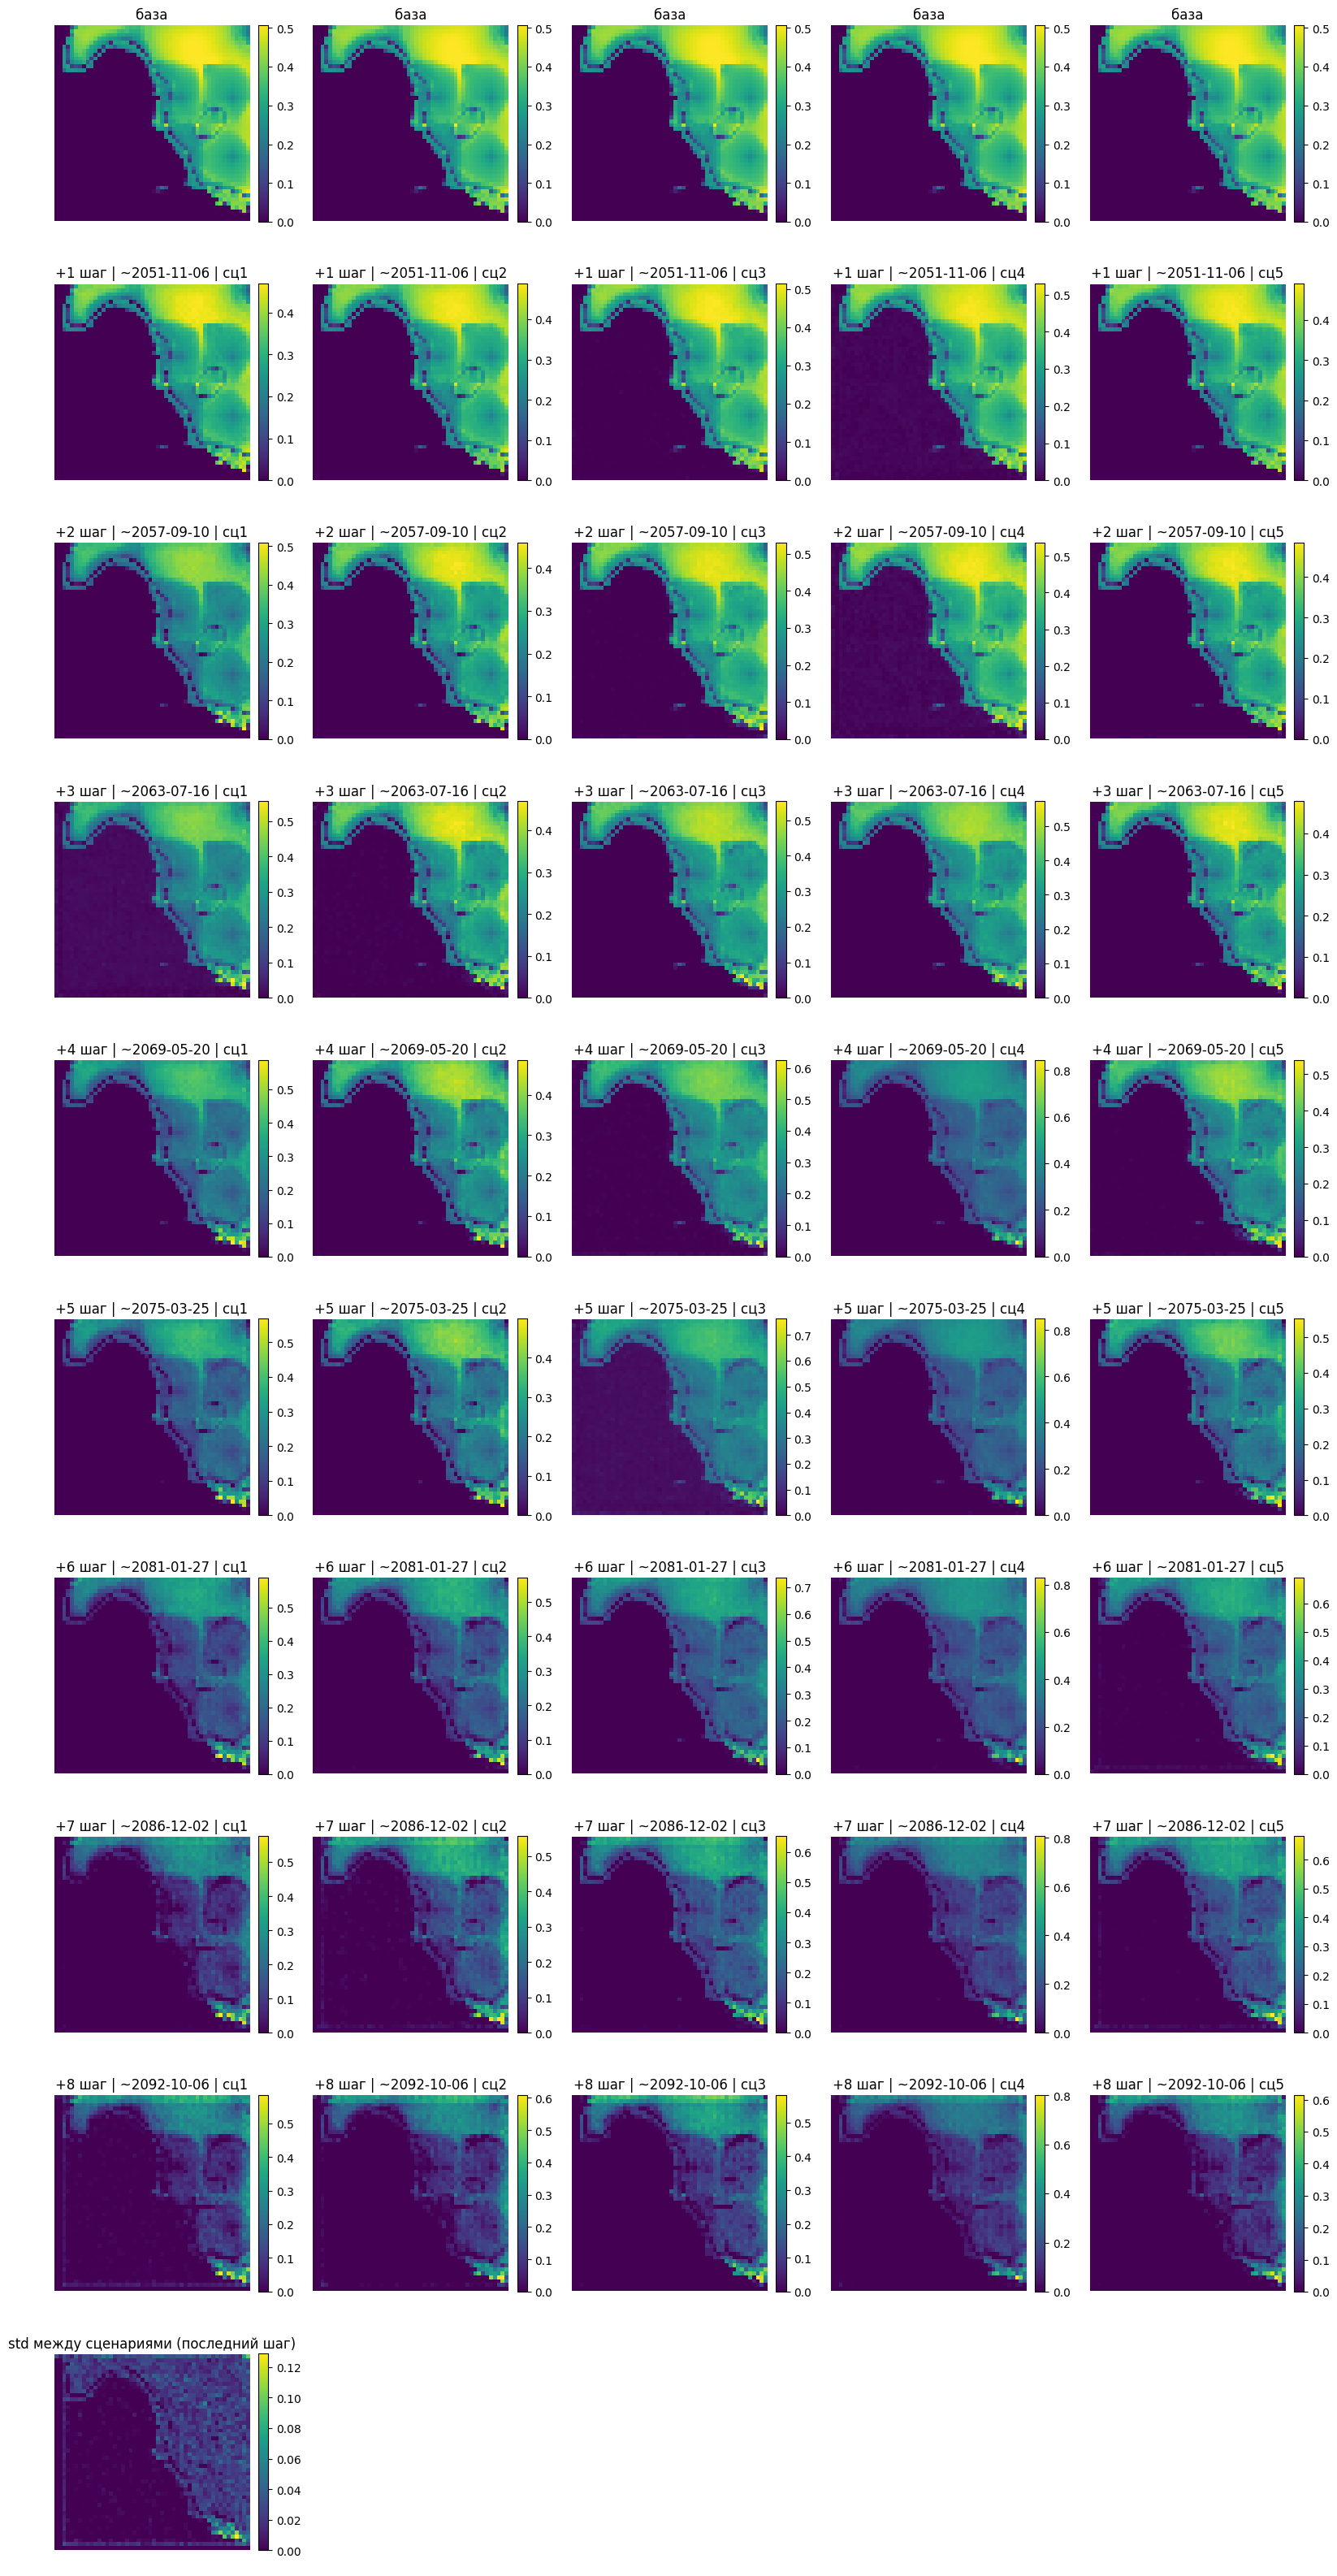

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from datetime import datetime

# =========================
# НАСТРОЙКИ (твои)
# =========================
scenarios_count = 5
maps_count = 10

horizon_years = None   # например 20
horizon_time = None    # если delta_mode="time" и хочешь нормированный горизонт 0..1
horizon_steps = None   # если delta_mode="index" можно задать шаги

forecast_mode = "auto"  # "auto" (autoregressive) или "from_base" (каждый шаг от исходной базы)
base_index_override = None
base_time_override = None
base_map_path = None

# =========================
# ЗАГРУЗКА ЧЕКПОИНТА (как у тебя)
# =========================
checkpoint_path = None
checkpoint_dir = Path(config["train"].get("checkpoint_dir", "checkpoints"))
if checkpoint_path is None:
    candidates = sorted(checkpoint_dir.glob("diffusion_epoch*.pt"), key=lambda p: p.stat().st_mtime)
    if candidates:
        checkpoint_path = candidates[-1]

if checkpoint_path is not None and Path(checkpoint_path).exists():
    diffusion.model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("загружен чекпоинт:", checkpoint_path)
else:
    print("чекпоинт не найден, используется текущая модель")

diffusion.eval()

# =========================
# helper: загрузить базовую карту
# =========================
def load_base_map(path: Path) -> np.ndarray:
    if path.suffix.lower() == ".npz":
        with np.load(path) as archive:
            if "saturation" in archive:
                base = archive["saturation"]
            elif "saturations" in archive:
                base = archive["saturations"][0]
            else:
                raise KeyError("В архиве нет ключей saturation или saturations.")
    else:
        base = np.load(path)
    # ожидаем 2D (H,W)
    if base.ndim != 2:
        raise ValueError("Базовая карта должна быть 2D (H,W) для текущей визуализации слоя.")
    return np.nan_to_num(base, nan=0.0).astype(np.float32)

def choose_base_index() -> int:
    if base_index_override is not None:
        return int(base_index_override)
    if val_subset is not None and getattr(val_subset, "indices", None):
        return int(val_subset.indices[0])
    return 0

def parse_dates(date_strings) -> list[datetime]:
    dates = []
    for item in date_strings:
        try:
            dates.append(datetime.strptime(str(item), "%Y-%m-%d"))
        except ValueError:
            # если не распарсилось — кладём None, чтобы индексы не “съезжали”
            dates.append(None)
    return dates

from datetime import timedelta

def build_step_labels_for_index_mode(base_t_index: int, ks: list[int], dataset) -> list[str]:
    """
    Возвращает подписи вида: "+k шаг | YYYY-MM-DD"
    1) Если дата t2 есть в датасете — берём её.
    2) Если t2 уже "за датасетом" (как у тебя при base_t=последний),
       то оцениваем дату как base_date + k * mean_step_days.
    """
    date_strings = getattr(dataset, "date_strings", None)
    if date_strings is None:
        return [f"+{k} шаг" for k in ks]

    # нормализуем строки (в npz часто бывают bytes)
    norm = []
    for x in date_strings:
        if isinstance(x, (bytes, np.bytes_)):
            x = x.decode("utf-8", errors="ignore")
        norm.append(str(x).strip())

    # парсим даты (сохраняем длину, чтобы индексы совпадали)
    dates = []
    for s in norm:
        d = None
        for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%Y-%m-%d %H:%M:%S", "%Y-%m-%dT%H:%M:%S"):
            try:
                d = datetime.strptime(s, fmt)
                break
            except Exception:
                pass
        dates.append(d)

    # считаем средний шаг (в днях) по тем датам, что распарсились
    good = [d for d in dates if d is not None]
    mean_days = None
    if len(good) >= 2:
        diffs = [(good[i+1] - good[i]).days for i in range(len(good)-1)]
        diffs = [d for d in diffs if d != 0]
        if diffs:
            mean_days = float(sum(diffs)) / float(len(diffs))

    base_date = dates[base_t_index] if 0 <= base_t_index < len(dates) else None

    labels = []
    for k in ks:
        t2 = int(base_t_index) + int(k)

        # 1) если в массиве есть дата t2 — берём её
        if 0 <= t2 < len(dates) and dates[t2] is not None:
            labels.append(f"+{k} шаг | {dates[t2].strftime('%Y-%m-%d')}")
            continue

        # 2) иначе — приблизительно от base_date
        if base_date is not None and mean_days is not None and mean_days > 0:
            approx = base_date + timedelta(days=mean_days * float(k))
            labels.append(f"+{k} шаг | ~{approx.strftime('%Y-%m-%d')}")
        else:
            labels.append(f"+{k} шаг")

    return labels

def build_even_steps(horizon: float, count: int) -> list[float]:
    count = max(1, int(count))
    horizon = max(0.0, float(horizon))
    step = horizon / count if count > 0 else 0.0
    return [step * (idx + 1) for idx in range(count)]

def compute_horizon(delta_mode: str, base_time: float, base_index: int) -> tuple[float, bool]:
    used_years = False
    if delta_mode == "time":
        horizon = None
        if horizon_years is not None:
            dates = parse_dates(getattr(dataset, "date_strings", []))
            good = [d for d in dates if d is not None]
            if len(good) >= 2:
                total_years = (good[-1] - good[0]).days / 365.25
                if total_years > 0:
                    horizon = float(horizon_years) / total_years
                    used_years = True
        if horizon is None and horizon_time is not None:
            horizon = float(horizon_time)
        if horizon is None:
            mean_delta = float(getattr(dataset, "mean_time_delta", 0.0))
            horizon = mean_delta * max(1, maps_count)

        max_delta = float(getattr(dataset, "times", np.array([1.0])).max()) - base_time
        if max_delta > 0 and horizon > max_delta:
            horizon = max_delta
        return horizon, used_years

    # delta_mode == "index"
    horizon = None
    if horizon_steps is not None:
        horizon = float(horizon_steps)
    elif horizon_years is not None:
        dates = parse_dates(getattr(dataset, "date_strings", []))
        good = [d for d in dates if d is not None]
        if len(good) >= 2:
            diffs = [(good[idx + 1] - good[idx]).days for idx in range(len(good) - 1)]
            step_years = (sum(diffs) / len(diffs)) / 365.25 if diffs else 0.0
            if step_years > 0:
                horizon = float(horizon_years) / step_years
                used_years = True
    if horizon is None:
        horizon = float(max(1, maps_count))

    max_delta = (dataset.saturations.shape[0] - 1) - base_index
    if max_delta > 0 and horizon > max_delta:
        horizon = max_delta
    return horizon, used_years

# ========= FIX: dataset alias =========
dataset = train_dataset  # важно!

DS_CLIP = float(getattr(dataset, "dS_clip", 0.1))
MAX_DELTA_STEPS = int(getattr(dataset, "max_delta_steps", 8))
delta_mode = str(getattr(dataset, "delta_mode", "index"))

# ========= choose base =========
base_t_index = dataset.saturations.shape[0] - 1   # последний t
base_z_index = dataset.layers // 2                # слой по центру
base_index = base_t_index

base_np = np.nan_to_num(dataset.saturations[base_t_index, base_z_index], nan=0.0).astype(np.float32)
base_time = float(dataset.times[base_t_index]) if hasattr(dataset, "times") else 0.0

# mask for this layer (2D!)
if hasattr(dataset, "actnum_mask"):
    act = dataset.actnum_mask
    act2d = act[base_z_index] if getattr(act, "ndim", 0) == 3 else act
    mask_np = act2d.astype(np.float32)
else:
    mask_np = np.ones_like(base_np, np.float32)

base01 = torch.from_numpy(base_np).to(device)[None, None]  # (1,1,H,W)
mask01 = torch.from_numpy(mask_np).to(device)[None, None]  # (1,1,H,W)

def apply_delta(base01: torch.Tensor, dS_norm: torch.Tensor, dS_clip: float = DS_CLIP) -> torch.Tensor:
    dS = dS_norm.clamp(-1, 1) * float(dS_clip)
    return (base01 + dS).clamp(0, 1)

def make_cond(
    base01: torch.Tensor,
    mask01: torch.Tensor,
    *,
    delta_norm: float,
    k: int,
    z_index: int,
    dataset,
) -> torch.Tensor:
    """
    base01/mask01: (B,1,H,W)
    returns cond: (B,C,H,W)
    """
    B, _, H, W = base01.shape
    cond_list = []
    for b in range(B):
        base_np = base01[b, 0].detach().cpu().numpy().astype(np.float32)  # (H,W)
        mask_np = mask01[b, 0].detach().cpu().numpy().astype(np.float32)  # (H,W)

        cond_np = build_cond_numpy(
            mask=mask_np,
            base01=base_np,
            delta_norm=float(delta_norm),
            k=int(k),
            z_index=int(z_index),
            layers=int(dataset.layers),
            delta_mode=str(dataset.delta_mode),
            max_delta_steps=int(dataset.max_delta_steps),
            delta_encoding=str(dataset.delta_encoding),
            z_encoding=str(dataset.z_encoding),
            delta_freqs=int(dataset.delta_freqs),
            z_freqs=int(dataset.z_freqs),
        )  # (C,H,W)

        cond_list.append(torch.from_numpy(cond_np))

    cond = torch.stack(cond_list, dim=0).to(base01.device).float()  # (B,C,H,W)
    return cond

# ========= rollout: one seed = one trajectory =========
def rollout_paths(
    base01, mask01, steps, scenarios, seed0=1234,
    forecast_mode="auto",        # "auto" | "from_base"
    k_schedule=None              # список горизонтов k (например [1,2,4,8]) или None
):
    """
    Первая версия (ячейка 15):
      - forecast_mode="auto": autoregressive траектория (сценарии развития)
      - forecast_mode="from_base": прогноз на горизонтах k от одной и той же базы (не траектория)
      - k_schedule: если задан, игнорирует steps и использует эти k (для index-mode)
    """
    paths = []
    for s in range(scenarios):
        torch.manual_seed(seed0 + s)

        # базовая карта: torch.Tensor [1,1,H,W]
        base0 = base01.clone()
        cur = base0.clone()
        scen = []

        # выбираем список шагов
        if (delta_mode == "index") and (k_schedule is not None):
            ks = list(map(int, k_schedule))
        else:
            # по умолчанию steps шагов
            ks = [1] * int(steps)  # для autoregressive
            if forecast_mode == "from_base" and delta_mode == "index":
                ks = list(range(1, int(steps) + 1))

        for i, k in enumerate(ks):
            if delta_mode == "index":
                # нормировка горизонта (0..1)
                delta_norm = float(k) / float(MAX_DELTA_STEPS)
            else:
                k = 1
                delta_norm = 1.0 / max(1, len(ks))

            # выбираем базу для conditioning
            if forecast_mode == "from_base":
                base_for_step = base0
            else:
                base_for_step = cur

            cond = make_cond(
                base_for_step, mask01,
                delta_norm=float(delta_norm),
                k=int(k),
                z_index=int(base_z_index),
                dataset=dataset
            )

            dS_norm = diffusion.sample(cond)
            nxt = apply_delta(base_for_step, dS_norm, dS_clip=DS_CLIP)

            # маска неактивных ячеек
            nxt = nxt * mask01 + base_for_step * (1 - mask01)

            scen.append(nxt.squeeze().detach().cpu().numpy())

            # обновляем состояние только в autoregressive режиме
            if forecast_mode != "from_base":
                cur = nxt

        paths.append(scen)

    return paths

# steps clamp for index-mode
if delta_mode == "index":
    steps = min(int(maps_count), int(MAX_DELTA_STEPS))
    ks_to_show = list(range(1, steps + 1))  # <-- NEW: горизонты и подписи (как во второй версии)
else:
    steps = int(maps_count)
    ks_to_show = None

paths = rollout_paths(
    base01, mask01,
    steps=steps,
    scenarios=int(scenarios_count),
    forecast_mode=forecast_mode,
    k_schedule=ks_to_show
)

# ====== NEW: подписи шагов с датами ======
if delta_mode == "index" and ks_to_show is not None:
    step_labels = build_step_labels_for_index_mode(base_t_index, ks_to_show, dataset)
else:
    step_labels = [f"шаг {i+1}" for i in range(steps)]

# ========= viz: grid (step x scenario) + std last =========
base_map = base01.squeeze().detach().cpu().numpy()
rows = 1 + steps + 1
cols = int(scenarios_count)
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.2), squeeze=False)

for c in range(cols):
    im = axes[0, c].imshow(base_map, origin="lower")
    axes[0, c].set_title("база")
    axes[0, c].axis("off")
    plt.colorbar(im, ax=axes[0, c], fraction=0.046, pad=0.04)

for i in range(steps):
    for s in range(cols):
        im = axes[i+1, s].imshow(paths[s][i], origin="lower")
        axes[i+1, s].set_title(f"{step_labels[i]} | сц{s+1}")  # <-- NEW
        axes[i+1, s].axis("off")
        plt.colorbar(im, ax=axes[i+1, s], fraction=0.046, pad=0.04)

last_maps = np.stack([paths[s][-1] for s in range(cols)], axis=0)
std_map = last_maps.std(axis=0)

im = axes[-1, 0].imshow(std_map, origin="lower")
axes[-1, 0].set_title("std между сценариями (последний шаг)")
axes[-1, 0].axis("off")
plt.colorbar(im, ax=axes[-1, 0], fraction=0.046, pad=0.04)
for c in range(1, cols):
    axes[-1, c].axis("off")

plt.tight_layout()
plt.show()


## Расширенный пайплайн: state/ΔS, VAE (latent), DDIM, adaptive clamp

Ниже — **добавочный блок** поверх базовой версии ноутбука. Он не ломает предыдущие ячейки, но даёт переключаемые фичи:

- `task.target_mode`: `"delta"` или `"state"`
- `latent.enabled`: True/False (VAE + диффузия в латенте)
- `sampling.sampler`: `"ddpm"` или `"ddim"` (+ `ddim_eta`, `clip_denoised`)
- `data.dS_clip`: `"auto_q99"` уже есть, + adaptive clamp на инференсе
- time-split уже есть: train/val/test по индексам t

Запускай этот блок после того, как выше определены: `encode_scalar_channel(...)`, `SimpleUNet`, `GaussianDiffusion`, `EMA` и утилиты.


In [9]:

# =========================
# КОНФИГ: расширения (добавляем поверх существующего config)
# =========================
config.setdefault("task", {})
config["task"].setdefault("target_mode", "delta")  # "delta" | "state"
config["task"].setdefault("forecast_mode", "auto")  # "auto" | "from_base"

config.setdefault("latent", {})
config["latent"].setdefault("enabled", False)  # True => VAE + диффузия в латенте
config["latent"].setdefault("latent_channels", 8)
config["latent"].setdefault("kl_beta", 1e-4)
config["latent"].setdefault("epochs", 40)
config["latent"].setdefault("lr", 2e-4)
config["latent"].setdefault("checkpoint_path", "checkpoints/vae.pt")

config.setdefault("sampling", {})
config["sampling"].setdefault("sampler", "ddim")  # "ddpm" | "ddim"
config["sampling"].setdefault("ddim_eta", 0.0)
config["sampling"].setdefault("clip_denoised", True)

config.setdefault("inference", {})
config["inference"].setdefault("adaptive_dS_clamp", True)
config["inference"].setdefault("dS_max_min_mult", 0.35)
config["inference"].setdefault("dS_max_max_mult", 2.50)
config["inference"].setdefault("scenarios_count", 8)
config["inference"].setdefault("maps_count", 8)
config["inference"].setdefault("seed0", 1234)

print("config(task/latent/sampling/inference):")
print({k: config[k] for k in ["task","latent","sampling","inference"]})


config(task/latent/sampling/inference):
{'task': {'target_mode': 'delta', 'forecast_mode': 'auto'}, 'latent': {'enabled': False, 'latent_channels': 8, 'kl_beta': 0.0001, 'epochs': 40, 'lr': 0.0002, 'checkpoint_path': 'checkpoints/vae.pt'}, 'sampling': {'sampler': 'ddim', 'ddim_eta': 0.0, 'clip_denoised': True}, 'inference': {'adaptive_dS_clamp': True, 'dS_max_min_mult': 0.35, 'dS_max_max_mult': 2.5, 'scenarios_count': 8, 'maps_count': 8, 'seed0': 1234}}


In [ ]:
# =========================
# КОНФИГ: расширения (добавляем поверх существующего config)
# =========================

# ---------- ЗАДАЧА ----------
config.setdefault("task", {})

# [ДО] Что именно предсказывает модель:
# "delta"  → модель предсказывает изменение насыщенности (стабильнее, безопаснее)
# "state"  → модель предсказывает сразу новую карту (смелее, но рискованнее)
config["task"].setdefault("target_mode", "delta")

# [ПОСЛЕ] Как считать прогноз:
# "auto"       → шаг за шагом во времени (реалистичное развитие процесса)
# "from_base"  → каждый прогноз считается от одной базовой карты (для сравнения горизонтов)
config["task"].setdefault("forecast_mode", "auto")


# ---------- ЛАТЕНТНОЕ ПРОСТРАНСТВО ----------
config.setdefault("latent", {})

# [ДО] Использовать ли сжатие карт (VAE):
# False → работать напрямую с картами (проще, нагляднее)
# True  → сначала сжать карту, потом диффузия (быстрее, но сложнее)
config["latent"].setdefault("enabled", False)

# [ДО] Размер латентного пространства:
# больше → больше деталей, медленнее
# меньше → сильнее сжатие, быстрее
config["latent"].setdefault("latent_channels", 8)

# [ДО] Вес регуляризации при обучении VAE:
# меньше → лучше восстанавливает детали
# больше → латент становится "аккуратнее", но может терять мелочи
config["latent"].setdefault("kl_beta", 1e-4)

# [ДО] Сколько эпох обучать VAE
config["latent"].setdefault("epochs", 40)

# [ДО] Скорость обучения VAE
config["latent"].setdefault("lr", 2e-4)

# [ДО] Где хранится чекпоинт VAE
config["latent"].setdefault("checkpoint_path", "checkpoints/vae.pt")


# ---------- ГЕНЕРАЦИЯ СЦЕНАРИЕВ (СЕМПЛИНГ) ----------
config.setdefault("sampling", {})

# [ПОСЛЕ] Способ генерации:
# "ddpm" → больше случайности, широкий разброс сценариев, больше шума
# "ddim" → управляемая генерация, стабильные и аккуратные карты
config["sampling"].setdefault("sampler", "ddim")

# [ПОСЛЕ] Сколько случайности добавлять (работает ТОЛЬКО для ddim):
# 0.0  → почти детерминированно, сценарии похожи
# 0.1–0.3 → разумный разброс сценариев
# 0.5+ → сильная вариативность, возможен шум
config["sampling"].setdefault("ddim_eta", 0.0)

# [ПОСЛЕ] Ограничивать ли значения внутри генерации:
# True  → стабильнее, меньше выбросов
# False → больше свободы, но риск развалов
config["sampling"].setdefault("clip_denoised", True)


# ---------- ИНФЕРЕНС / СЦЕНАРИИ ----------
config.setdefault("inference", {})

# [ПОСЛЕ] Ограничивать ли резкие скачки насыщенности между шагами:
# True  → физически правдоподобнее, меньше "рваных" карт
# False → больше свободы, но возможен шум
config["inference"].setdefault("adaptive_dS_clamp", True)

# [ПОСЛЕ] Минимальный множитель допустимого изменения:
# меньше → сильнее зажим на ранних шагах
config["inference"].setdefault("dS_max_min_mult", 0.35)

# [ПОСЛЕ] Максимальный множитель допустимого изменения:
# больше → разрешает более смелые изменения на дальнем прогнозе
config["inference"].setdefault("dS_max_max_mult", 2.50)

# [ПОСЛЕ] Сколько сценариев генерировать:
# больше → лучше оценка неопределённости, дольше считаем
config["inference"].setdefault("scenarios_count", 8)

# [ПОСЛЕ] Сколько карт показывать по времени в каждом сценарии
config["inference"].setdefault("maps_count", 8)

# [ПОСЛЕ] Базовый сид случайности:
# меняйте, если хотите другой набор сценариев
config["inference"].setdefault("seed0", 1234)


# ---------- ПЕЧАТЬ ТЕКУЩИХ НАСТРОЕК ----------
print("config(task/latent/sampling/inference):")
print({k: config[k] for k in ["task", "latent", "sampling", "inference"]})


In [11]:

# =========================
# DDIM sampler + clip_denoised (расширение GaussianDiffusion)
# =========================
class GaussianDiffusionV2(GaussianDiffusion):
    # Расширяем базовый DDPM:
    # - sampler: "ddpm" (как было) или "ddim"
    # - ddim_eta: 0.0 => детерминированный DDIM
    # - clip_denoised: клип x0 в clip_range (по умолчанию [-1,1])

    @torch.no_grad()
    def sample(
        self,
        cond: torch.Tensor,
        sampler: str = "ddpm",
        ddim_eta: float = 0.0,
        clip_denoised: bool = True,
        clip_range: tuple[float, float] = (-1.0, 1.0),
    ) -> torch.Tensor:
        sampler = str(sampler).lower().strip()
        if sampler not in {"ddpm", "ddim"}:
            raise ValueError(f"sampler must be 'ddpm' or 'ddim', got: {sampler}")

        batch_size = cond.shape[0]
        shape = (batch_size, self.out_channels, cond.shape[-2], cond.shape[-1])
        device = cond.device
        x = torch.randn(shape, device=device)

        if sampler == "ddpm":
            for i in reversed(range(self.timesteps)):
                t = torch.full((batch_size,), i, device=device, dtype=torch.long)
                x = self.p_sample(x, cond, t)
            return x

        # DDIM
        eta = float(ddim_eta)
        for i in reversed(range(self.timesteps)):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)

            # предсказание шума eps
            eps = self.model(x, cond, t)

            # x0 предсказание
            a_bar_t = self._extract(self.alphas_cumprod, t, x.shape)
            sqrt_a_bar_t = torch.sqrt(a_bar_t)
            sqrt_one_minus = torch.sqrt(1.0 - a_bar_t)
            x0 = (x - sqrt_one_minus * eps) / (sqrt_a_bar_t + 1e-8)

            if clip_denoised:
                lo, hi = clip_range
                x0 = torch.clamp(x0, lo, hi)

            if i == 0:
                x = x0
                continue

            t_prev = torch.full((batch_size,), i - 1, device=device, dtype=torch.long)
            a_bar_prev = self._extract(self.alphas_cumprod, t_prev, x.shape)

            sigma = (
                eta
                * torch.sqrt((1.0 - a_bar_prev) / (1.0 - a_bar_t + 1e-8))
                * torch.sqrt(1.0 - a_bar_t / (a_bar_prev + 1e-8))
            )

            dir_xt = torch.sqrt(torch.clamp(1.0 - a_bar_prev - sigma**2, min=0.0)) * eps
            noise = sigma * torch.randn_like(x)
            x = torch.sqrt(a_bar_prev) * x0 + dir_xt + noise

        return x


In [12]:

# =========================
# VAE2D: "канальный" VAE (простая стабильная версия для 50x50)
# =========================
class VAE2D(nn.Module):
    '''
    ВАЖНО: VAE без пространственного даунсэмплинга (H,W остаются 50x50),
    но с компрессией по каналам. Это проще и стабильно для старта.
    '''

    def __init__(self, in_ch: int = 1, latent_ch: int = 8, hidden: int = 64):
        super().__init__()
        self.latent_ch = int(latent_ch)

        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, hidden, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.SiLU(),
        )
        self.to_mu = nn.Conv2d(hidden, self.latent_ch, 1)
        self.to_logvar = nn.Conv2d(hidden, self.latent_ch, 1)

        self.dec = nn.Sequential(
            nn.Conv2d(self.latent_ch, hidden, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden, in_ch, 3, padding=1),
        )

    def encode(self, x: torch.Tensor):
        h = self.enc(x)
        return self.to_mu(h), self.to_logvar(h)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.dec(z)

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def vae_loss_masked(recon, x, mu, logvar, mask, beta: float):
    mse = ((recon - x) ** 2) * mask
    rec = mse.sum() / (mask.sum() * x.shape[1] + 1e-8)

    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl = kl.mean()

    loss = rec + float(beta) * kl
    return loss, {"rec": float(rec.detach()), "kl": float(kl.detach())}


@torch.no_grad()
def vae_encode_mean(vae: VAE2D, x: torch.Tensor) -> torch.Tensor:
    mu, _ = vae.encode(x)
    return mu


def train_vae_if_needed(vae: VAE2D, train_loader: DataLoader, device: torch.device, ckpt_path: str,
                        epochs: int = 40, lr: float = 2e-4, beta: float = 1e-4):
    ckpt_path = str(ckpt_path)
    os.makedirs(Path(ckpt_path).parent, exist_ok=True)

    if Path(ckpt_path).exists():
        state = torch.load(ckpt_path, map_location="cpu")
        vae.load_state_dict(state["vae"])
        print(f"[VAE] loaded: {ckpt_path}")
        return

    print(f"[VAE] training: epochs={epochs}, lr={lr}, beta={beta}")
    vae.to(device)
    opt = torch.optim.AdamW(vae.parameters(), lr=lr)

    vae.train()
    for ep in range(1, epochs + 1):
        rec_avg, kl_avg, n = 0.0, 0.0, 0
        for batch in train_loader:
            x = batch["target"].to(device)   # (B,1,H,W)
            mask = batch["mask"].to(device)  # (B,1,H,W)

            recon, mu, logvar = vae(x)
            loss, parts = vae_loss_masked(recon, x, mu, logvar, mask, beta)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            rec_avg += parts["rec"]
            kl_avg += parts["kl"]
            n += 1

        if ep % max(1, epochs // 10) == 0 or ep == 1:
            print(f"[VAE] ep={ep:03d}/{epochs} rec={rec_avg/max(n,1):.6f} kl={kl_avg/max(n,1):.6f}")

    torch.save({"vae": vae.state_dict()}, ckpt_path)
    print(f"[VAE] saved: {ckpt_path}")


In [13]:

# =========================
# ДАТАСЕТ V2: base/mask/target + delta_norm/z_norm (target_mode: delta/state)
# =========================
def norm_state01_to_n11(x01: np.ndarray) -> np.ndarray:
    return (x01 * 2.0 - 1.0).astype(np.float32)

def denorm_state_n11_to_01(xn: np.ndarray) -> np.ndarray:
    return np.clip((xn + 1.0) * 0.5, 0.0, 1.0).astype(np.float32)


class GDMForecastDatasetV2(torch.utils.data.Dataset):
    '''
    Возвращает dict:
      base: (1,H,W) в [-1,1]
      mask: (1,H,W) 0/1 (actnum & finite(base) & finite(target))
      target: (1,H,W) в [-1,1] (state) или dS_norm в [-1,1] (delta)
      delta_norm, z_norm: (1,)
    '''

    def __init__(self, data_path: Path, base_times: list[int], target_times: list[int],
                 delta_mode: str, max_delta_steps: int, dS_clip: float, target_mode: str = "delta",
                 delta_encoding: str = "embed", delta_freqs: int = 8,
                 z_encoding: str = "embed", z_freqs: int = 4):
        data = np.load(data_path)
        self.sat_raw = data["saturations"].astype(np.float32)
        self.saturations = np.nan_to_num(self.sat_raw, nan=0.0).astype(np.float32)  # 0..1
        self.actnum = data.get("actnum_mask", None)
        if self.actnum is None:
            self.actnum = np.isfinite(self.sat_raw[0, 0])
        self.actnum = self.actnum.astype(bool)
        # если 2D — ок, оставим 2D

        self.times = data.get("times", None)

        self.delta_mode = str(delta_mode)
        self.max_delta_steps = int(max_delta_steps)
        self.dS_clip = float(dS_clip)
        self.target_mode = str(target_mode)

        self.delta_encoding = str(delta_encoding)
        self.delta_freqs = int(delta_freqs)
        self.z_encoding = str(z_encoding)
        self.z_freqs = int(z_freqs)

        T, Z, H, W = self.saturations.shape
        self.T, self.layers, self.H, self.W = self.saturations.shape

        base_set = set(int(x) for x in base_times)
        targ_set = set(int(x) for x in target_times)

        samples = []
        for t in range(T):
            if t not in base_set:
                continue
            for k in range(1, self.max_delta_steps + 1):
                t2 = t + k
                if t2 >= T:
                    continue
                if t2 not in targ_set:
                    continue
                for z in range(Z):
                    if self.delta_mode == "index":
                        delta = float(k)
                    else:
                        delta = float(self.times[t2] - self.times[t]) if self.times is not None else float(k)
                    samples.append((t, z, k, delta, t2))
        self.samples = samples

        dummy_delta = encode_scalar_channel(0.5, encoding=self.delta_encoding, n_freq=self.delta_freqs, onehot_size=self.max_delta_steps, onehot_kind="delta", max_delta_steps=self.max_delta_steps)
        dummy_z = encode_scalar_channel(0.5, encoding=self.z_encoding, n_freq=self.z_freqs, onehot_size=self.layers, onehot_kind="z")
        self.cond_channels = 1 + 1 + int(dummy_delta.shape[0]) + int(dummy_z.shape[0])

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        t, z, k, delta, t2 = self.samples[idx]
        base01 = self.saturations[t, z]
        targ01 = self.saturations[t2, z]

        base_ok = np.isfinite(self.sat_raw[t, z])
        targ_ok = np.isfinite(self.sat_raw[t2, z])
        act2d = self.actnum[z] if self.actnum.ndim == 3 else self.actnum
        mask = (act2d & base_ok & targ_ok).astype(np.float32)


        if self.delta_mode == "index":
            delta_norm = float(k) / float(max(1, self.max_delta_steps))
        else:
            total = float(self.times[-1] - self.times[0]) if self.times is not None else 1.0
            delta_norm = float(delta) / total if total > 0 else 0.0

        z_norm = 0.0 if self.layers <= 1 else float(z) / float(self.layers - 1)

        base_n = norm_state01_to_n11(base01)

        if self.target_mode == "state":
            target_n = norm_state01_to_n11(targ01)
        else:
            dS = (targ01 - base01).astype(np.float32)
            target_n = np.clip(dS / self.dS_clip, -1.0, 1.0).astype(np.float32)

        return {
            "base": torch.from_numpy(base_n)[None],
            "mask": torch.from_numpy(mask)[None],
            "target": torch.from_numpy(target_n)[None],
            "delta_norm": torch.tensor([delta_norm], dtype=torch.float32),
            "z_norm": torch.tensor([z_norm], dtype=torch.float32),
        }


In [14]:

# =========================
# FULL train: pixel/latent + EMA + DDIM
# =========================
def build_cond_from_batch(batch: dict, device: torch.device,
                          delta_encoding: str, delta_freqs: int,
                          z_encoding: str, z_freqs: int,
                          base_latent: torch.Tensor | None = None) -> torch.Tensor:
    mask = batch["mask"].to(device)  # (B,1,H,W)
    if base_latent is None:
        base = batch["base"].to(device)  # (B,1,H,W)
    else:
        base = base_latent  # (B,C,H,W)

    dn = batch["delta_norm"].to(device).view(-1)
    zn = batch["z_norm"].to(device).view(-1)

    max_delta_steps = int(config["data"]["max_delta_steps"])
    layers = int(config["data"].get("layers", GDM_LAYERS))
    delta_mode = str(config["data"]["delta_mode"])
    if delta_encoding == "onehot" and delta_mode != "index":
        raise ValueError("delta_encoding='onehot' разрешен только при delta_mode='index'.")

    delta_vecs, z_vecs = [], []
    for i in range(dn.shape[0]):
        d_np = encode_scalar_channel(float(dn[i].item()), encoding=delta_encoding, n_freq=delta_freqs, onehot_size=max_delta_steps, onehot_kind="delta", max_delta_steps=max_delta_steps)
        z_np = encode_scalar_channel(float(zn[i].item()), encoding=z_encoding, n_freq=z_freqs, onehot_size=layers, onehot_kind="z")
        delta_vecs.append(torch.from_numpy(d_np))
        z_vecs.append(torch.from_numpy(z_np))
    delta_vecs = torch.stack(delta_vecs, dim=0).to(device)
    z_vecs = torch.stack(z_vecs, dim=0).to(device)

    H, W = mask.shape[-2], mask.shape[-1]
    delta_maps = delta_vecs[:, :, None, None].expand(-1, -1, H, W)
    z_maps = z_vecs[:, :, None, None].expand(-1, -1, H, W)

    return torch.cat([mask, base, delta_maps, z_maps], dim=1)


def adaptive_dS_max(delta_norm: float, cfg: dict, base_scale: float) -> float:
    a0 = float(cfg.get("dS_max_min_mult", 0.35))
    a1 = float(cfg.get("dS_max_max_mult", 2.50))
    dn = float(np.clip(delta_norm, 0.0, 1.0))
    return float(base_scale) * (a0 + (a1 - a0) * dn)


def train_full_pipeline():
    device = resolve_device(config["train"].get("device"), None)
    print("device:", device)

    data_path = Path(config["data"]["path"])
    ckpt_dir = Path(config["train"].get("checkpoint_dir", "checkpoints"))
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    delta_mode = config["data"]["delta_mode"]
    max_delta_steps = int(config["data"]["max_delta_steps"])
    train_times = list(config["data"]["train_times"])
    val_times = list(config["data"]["val_times"])

    # dS_clip (float или auto_q..)
    dS_clip_cfg = config["data"]["dS_clip"]
    if isinstance(dS_clip_cfg, (int, float)):
        dS_clip = float(dS_clip_cfg)
    else:
        q = 0.99
        if isinstance(dS_clip_cfg, str) and "q" in dS_clip_cfg:
            try:
                q = float("0." + dS_clip_cfg.split("q",1)[1])
            except Exception:
                q = 0.99
        dS_clip = estimate_ds_clip_from_pairs(
            data_path,
            base_times=train_times,
            target_times=train_times,
            max_delta_steps=max_delta_steps,
            delta_mode=delta_mode,
            quantile=q,
        )
    print("dS_clip:", dS_clip)

    target_mode = config["task"]["target_mode"]
    delta_encoding = config["data"]["delta_encoding"]
    delta_freqs = int(config["data"]["delta_freqs"])
    z_encoding = config["data"]["z_encoding"]
    z_freqs = int(config["data"]["z_freqs"])

    train_ds = GDMForecastDatasetV2(
        data_path, base_times=train_times, target_times=train_times,
        delta_mode=delta_mode, max_delta_steps=max_delta_steps, dS_clip=dS_clip,
        target_mode=target_mode, delta_encoding=delta_encoding, delta_freqs=delta_freqs,
        z_encoding=z_encoding, z_freqs=z_freqs
    )
    val_ds = GDMForecastDatasetV2(
        data_path, base_times=val_times, target_times=val_times,
        delta_mode=delta_mode, max_delta_steps=max_delta_steps, dS_clip=dS_clip,
        target_mode=target_mode, delta_encoding=delta_encoding, delta_freqs=delta_freqs,
        z_encoding=z_encoding, z_freqs=z_freqs
    )

    layers = train_ds.layers
    print("train samples:", len(train_ds), "val samples:", len(val_ds))

    train_loader = DataLoader(train_ds, batch_size=int(config["train"]["batch_size"]), shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=int(config["train"]["batch_size"]), shuffle=False, num_workers=0)

    latent_enabled = bool(config["latent"]["enabled"])
    latent_ch = int(config["latent"]["latent_channels"])

    if latent_enabled:
        vae = VAE2D(in_ch=1, latent_ch=latent_ch, hidden=64)
        train_vae_if_needed(
            vae, train_loader=train_loader, device=device,
            ckpt_path=config["latent"]["checkpoint_path"],
            epochs=int(config["latent"]["epochs"]),
            lr=float(config["latent"]["lr"]),
            beta=float(config["latent"]["kl_beta"]),
        )
        vae.to(device).eval()
    else:
        vae = None

    dummy_delta = encode_scalar_channel(0.5, encoding=delta_encoding, n_freq=delta_freqs, onehot_size=max_delta_steps, onehot_kind="delta", max_delta_steps=max_delta_steps)
    dummy_z = encode_scalar_channel(0.5, encoding=z_encoding, n_freq=z_freqs, onehot_size=layers, onehot_kind="z")
    cond_channels = 1 + (latent_ch if latent_enabled else 1) + int(dummy_delta.shape[0]) + int(dummy_z.shape[0])
    target_channels = latent_ch if latent_enabled else 1

    unet = SimpleUNet(
        target_channels=target_channels,
        cond_channels=cond_channels,
        base_channels=int(config["model"]["base_channels"]),
    ).to(device)

    diffusion = GaussianDiffusionV2(
        model=unet,
        timesteps=int(config["diffusion"]["timesteps"]),
        beta_start=float(config["diffusion"]["beta_start"]),
        beta_end=float(config["diffusion"]["beta_end"]),
    ).to(device)

    lr = float(config["train"].get("learning_rate", config["train"].get("lr", 1e-4)))
    opt = torch.optim.AdamW(diffusion.parameters(), lr=lr)
    print("lr:", lr)

    use_ema = bool(config["train"].get("use_ema", True))
    ema = EMA(diffusion.model, decay=float(config["train"].get("ema_decay", 0.999))) if use_ema else None

    best_val = float("inf")
    ckpt_path = ckpt_dir / "diffusion_best.pt"

    for epoch in range(1, int(config["train"]["epochs"]) + 1):
        diffusion.train()
        tr, n = 0.0, 0
        for batch in train_loader:
            target = batch["target"].to(device)

            if latent_enabled:
                with torch.no_grad():
                    base_lat = vae_encode_mean(vae, batch["base"].to(device))
                    target_lat = vae_encode_mean(vae, target)
                cond = build_cond_from_batch(batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=base_lat)
                loss = diffusion.p_losses(target_lat, cond)
            else:
                cond = build_cond_from_batch(batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=None)
                loss = diffusion.p_losses(target, cond)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
            opt.step()
            if ema is not None:
                ema.update(diffusion.model)

            tr += float(loss.detach().cpu())
            n += 1

        diffusion.eval()
        if ema is not None:
            ema.apply_to(diffusion.model)

        va, m = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                target = batch["target"].to(device)
                if latent_enabled:
                    base_lat = vae_encode_mean(vae, batch["base"].to(device))
                    target_lat = vae_encode_mean(vae, target)
                    cond = build_cond_from_batch(batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=base_lat)
                    l = diffusion.p_losses(target_lat, cond)
                else:
                    cond = build_cond_from_batch(batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=None)
                    l = diffusion.p_losses(target, cond)
                va += float(l.detach().cpu())
                m += 1

        if ema is not None:
            ema.restore(diffusion.model)

        tr_loss = tr / max(1, n)
        va_loss = va / max(1, m)
        print(f"epoch {epoch:03d} train={tr_loss:.6f} val={va_loss:.6f}")

        if va_loss < best_val:
            best_val = va_loss
            payload = {
                "diffusion": diffusion.state_dict(),
                "config": config,
                "dS_clip": dS_clip,
                "latent_enabled": latent_enabled,
                "latent_ch": latent_ch,
            }
            if ema is not None:
                payload["ema_shadow"] = {k: v.detach().cpu() for k, v in ema.shadow.items()}
            if vae is not None:
                payload["vae"] = vae.state_dict()
            torch.save(payload, ckpt_path)
            print("  saved:", ckpt_path)

    print("best val:", best_val, "saved to:", ckpt_path)
    return str(ckpt_path)

# запуск (раскомментируй):
ckpt = train_full_pipeline()


device: cuda
dS_clip: 0.28363528847694397
train samples: 750 val samples: 50
lr: 0.0002
epoch 001 train=0.603709 val=1.066564
  saved: checkpoints/diffusion_best.pt
epoch 002 train=0.184008 val=1.051935
  saved: checkpoints/diffusion_best.pt
epoch 003 train=0.121309 val=1.013628
  saved: checkpoints/diffusion_best.pt
epoch 004 train=0.095155 val=0.972676
  saved: checkpoints/diffusion_best.pt
epoch 005 train=0.079535 val=0.950290
  saved: checkpoints/diffusion_best.pt
epoch 006 train=0.067243 val=0.890259
  saved: checkpoints/diffusion_best.pt
epoch 007 train=0.059620 val=0.860965
  saved: checkpoints/diffusion_best.pt
epoch 008 train=0.050727 val=0.798149
  saved: checkpoints/diffusion_best.pt
epoch 009 train=0.051851 val=0.794574
  saved: checkpoints/diffusion_best.pt
epoch 010 train=0.048590 val=0.737812
  saved: checkpoints/diffusion_best.pt
epoch 011 train=0.040434 val=0.698225
  saved: checkpoints/diffusion_best.pt
epoch 012 train=0.041264 val=0.645626
  saved: checkpoints/diffus

In [15]:
@torch.no_grad()
def load_full_pipeline(ckpt_path: str, device: torch.device, *, layers: int, max_delta_steps: int):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = ckpt.get("config", config)

    latent_enabled = bool(ckpt.get("latent_enabled", cfg.get("latent", {}).get("enabled", False)))
    latent_ch = int(ckpt.get("latent_ch", cfg.get("latent", {}).get("latent_channels", 8)))

    delta_encoding = cfg["data"]["delta_encoding"]
    delta_freqs = int(cfg["data"]["delta_freqs"])
    z_encoding = cfg["data"]["z_encoding"]
    z_freqs = int(cfg["data"]["z_freqs"])

    # ВАЖНО: max_delta_steps/layers теперь приходят параметрами
    dummy_delta = encode_scalar_channel(
        0.5, encoding=delta_encoding, n_freq=delta_freqs,
        onehot_size=int(max_delta_steps), onehot_kind="delta",
        max_delta_steps=int(max_delta_steps)
    )
    dummy_z = encode_scalar_channel(
        0.5, encoding=z_encoding, n_freq=z_freqs,
        onehot_size=int(layers), onehot_kind="z"
    )

    cond_channels = 1 + (latent_ch if latent_enabled else 1) + int(dummy_delta.shape[0]) + int(dummy_z.shape[0])
    target_channels = latent_ch if latent_enabled else 1

    unet = SimpleUNet(
        target_channels=target_channels,
        cond_channels=cond_channels,
        base_channels=int(cfg["model"]["base_channels"]),
    ).to(device)

    diffusion = GaussianDiffusionV2(
        model=unet,
        timesteps=int(cfg["diffusion"]["timesteps"]),
        beta_start=float(cfg["diffusion"]["beta_start"]),
        beta_end=float(cfg["diffusion"]["beta_end"]),
    ).to(device)

    diffusion.load_state_dict(ckpt["diffusion"], strict=True)
    diffusion.eval()

    if "ema_shadow" in ckpt:
        ema = EMA(diffusion.model, decay=float(cfg["train"].get("ema_decay", 0.999)))
        ema.shadow = {k: v.to(device) for k, v in ckpt["ema_shadow"].items()}
        ema.apply_to(diffusion.model)
        print("[load] EMA applied")

    if latent_enabled:
        vae = VAE2D(in_ch=1, latent_ch=latent_ch, hidden=64).to(device)
        if "vae" in ckpt:
            vae.load_state_dict(ckpt["vae"], strict=False)
        vae.eval()
    else:
        vae = None

    dS_clip = float(ckpt.get("dS_clip", cfg["data"].get("dS_clip", 0.1)))
    return diffusion, vae, dS_clip, cfg

@torch.no_grad()
def rollout_scenarios_full(data_path: str, ckpt_path: str, start_t: int = 0, start_z: int = 0):
    device = resolve_device(config["train"].get("device"), None)

    data = np.load(data_path)
    sat_raw = data["saturations"].astype(np.float32)   # (T,Z,H,W)
    actnum = data.get("actnum_mask", None)

    T, Z, H, W = sat_raw.shape
    layers = Z

    # actnum -> 2D маска для текущего слоя
    if actnum is None:
        act2d = np.isfinite(sat_raw[0, start_z])
    else:
        actnum = actnum.astype(bool)
        act2d = actnum[start_z] if actnum.ndim == 3 else actnum

    # max_delta_steps лучше брать из чекпоинта/конфига позже, но для load нужны оба:
    # возьмем из глобального config как fallback, потом уточним из cfg
    max_delta_steps_guess = int(config["data"].get("max_delta_steps", 8))

    diffusion, vae, dS_clip, cfg = load_full_pipeline(
        ckpt_path, device=device,
        layers=layers,
        max_delta_steps=max_delta_steps_guess
    )

    # теперь уже точно берем из cfg
    target_mode = cfg["task"]["target_mode"]
    delta_mode = cfg["data"]["delta_mode"]
    max_delta_steps = int(cfg["data"]["max_delta_steps"])

    # базовая карта
    base01 = np.nan_to_num(sat_raw[start_t, start_z], nan=0.0).astype(np.float32)
    base_ok = np.isfinite(sat_raw[start_t, start_z])
    mask = (act2d & base_ok).astype(np.float32)  # (H,W) !!!

    sampler = cfg["sampling"]["sampler"]
    eta = float(cfg["sampling"]["ddim_eta"])
    clip_denoised = bool(cfg["sampling"]["clip_denoised"])
    clip_range = (-1.0, 1.0)

    delta_encoding = cfg["data"]["delta_encoding"]
    delta_freqs = int(cfg["data"]["delta_freqs"])
    z_encoding = cfg["data"]["z_encoding"]
    z_freqs = int(cfg["data"]["z_freqs"])

    scenarios = int(cfg["inference"]["scenarios_count"])
    steps = int(cfg["inference"]["maps_count"])
    seed0 = int(cfg["inference"]["seed0"])

    if delta_mode == "index":
        steps = min(steps, max_delta_steps)

    z_norm = 0.0 if layers <= 1 else float(start_z) / float(layers - 1)

    results = []
    for s in range(scenarios):
        torch.manual_seed(seed0 + s)
        cur01 = base01.copy()
        scen = []

        for i in range(steps):
            # ---- выбрать delta_norm ----
            if delta_mode == "index":
                k = i + 1
                delta_norm = float(k) / float(max(1, max_delta_steps))
            else:
                delta_norm = float(i + 1) / float(max(1, steps))

            # ---- подготовить batch ----
            base_n = norm_state01_to_n11(cur01)[None, None]  # (1,1,H,W)
            base_t = torch.from_numpy(base_n.astype(np.float32)).to(device)  # (1,1,H,W)
            mask_t = torch.from_numpy(mask.astype(np.float32))[None, None].to(device)  # (1,1,H,W)

            batch = {
                "mask": mask_t,
                "base": base_t,  # НЕ squeeze
                "delta_norm": torch.tensor([delta_norm], dtype=torch.float32).to(device),
                "z_norm": torch.tensor([z_norm], dtype=torch.float32).to(device),
            }

            # ---- сэмпл ----
            if vae is not None:
                base_lat = vae_encode_mean(vae, batch["base"])  # (B,latent?,H,W) по твоей реализации
                cond = build_cond_from_batch(
                    batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=base_lat
                )
                out_lat = diffusion.sample(
                    cond, sampler=sampler, ddim_eta=eta, clip_denoised=clip_denoised, clip_range=clip_range
                )
                out_n = vae.decode(out_lat).detach().cpu().numpy()[0, 0]
            else:
                cond = build_cond_from_batch(
                    batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=None
                )
                out = diffusion.sample(
                    cond, sampler=sampler, ddim_eta=eta, clip_denoised=clip_denoised, clip_range=clip_range
                )
                out_n = out.detach().cpu().numpy()[0, 0]

            # ---- превратить out_n в nxt01 (ЭТО ДОЛЖНО БЫТЬ И ДЛЯ VAE, И ДЛЯ НЕ VAE) ----
            if target_mode == "state":
                nxt01 = denorm_state_n11_to_01(out_n)
            else:
                dS = (out_n * float(dS_clip)).astype(np.float32)
                if bool(cfg["inference"]["adaptive_dS_clamp"]):
                    dS_max = adaptive_dS_max(delta_norm, cfg["inference"], base_scale=float(dS_clip))
                    dS = np.clip(dS, -dS_max, dS_max)
                nxt01 = np.clip(cur01 + dS, 0.0, 1.0).astype(np.float32)

            # ---- маска и апдейт траектории ----
            nxt01 = nxt01 * mask + cur01 * (1.0 - mask)
            scen.append(nxt01.copy())
            cur01 = nxt01

        results.append(scen)

    return results

# пример:
ckpt = "checkpoints/diffusion_best.pt"
results = rollout_scenarios_full("gdm_saturation.npz", ckpt_path=ckpt, start_t=0, start_z=0)
print(len(results), len(results[0]))


[load] EMA applied
8 8


## Визуализация результатов rollout_scenarios_full

Сетка `шаг × сценарий` + карты среднего и стандартного отклонения по ансамблю на выбранном шаге.


[load] EMA applied


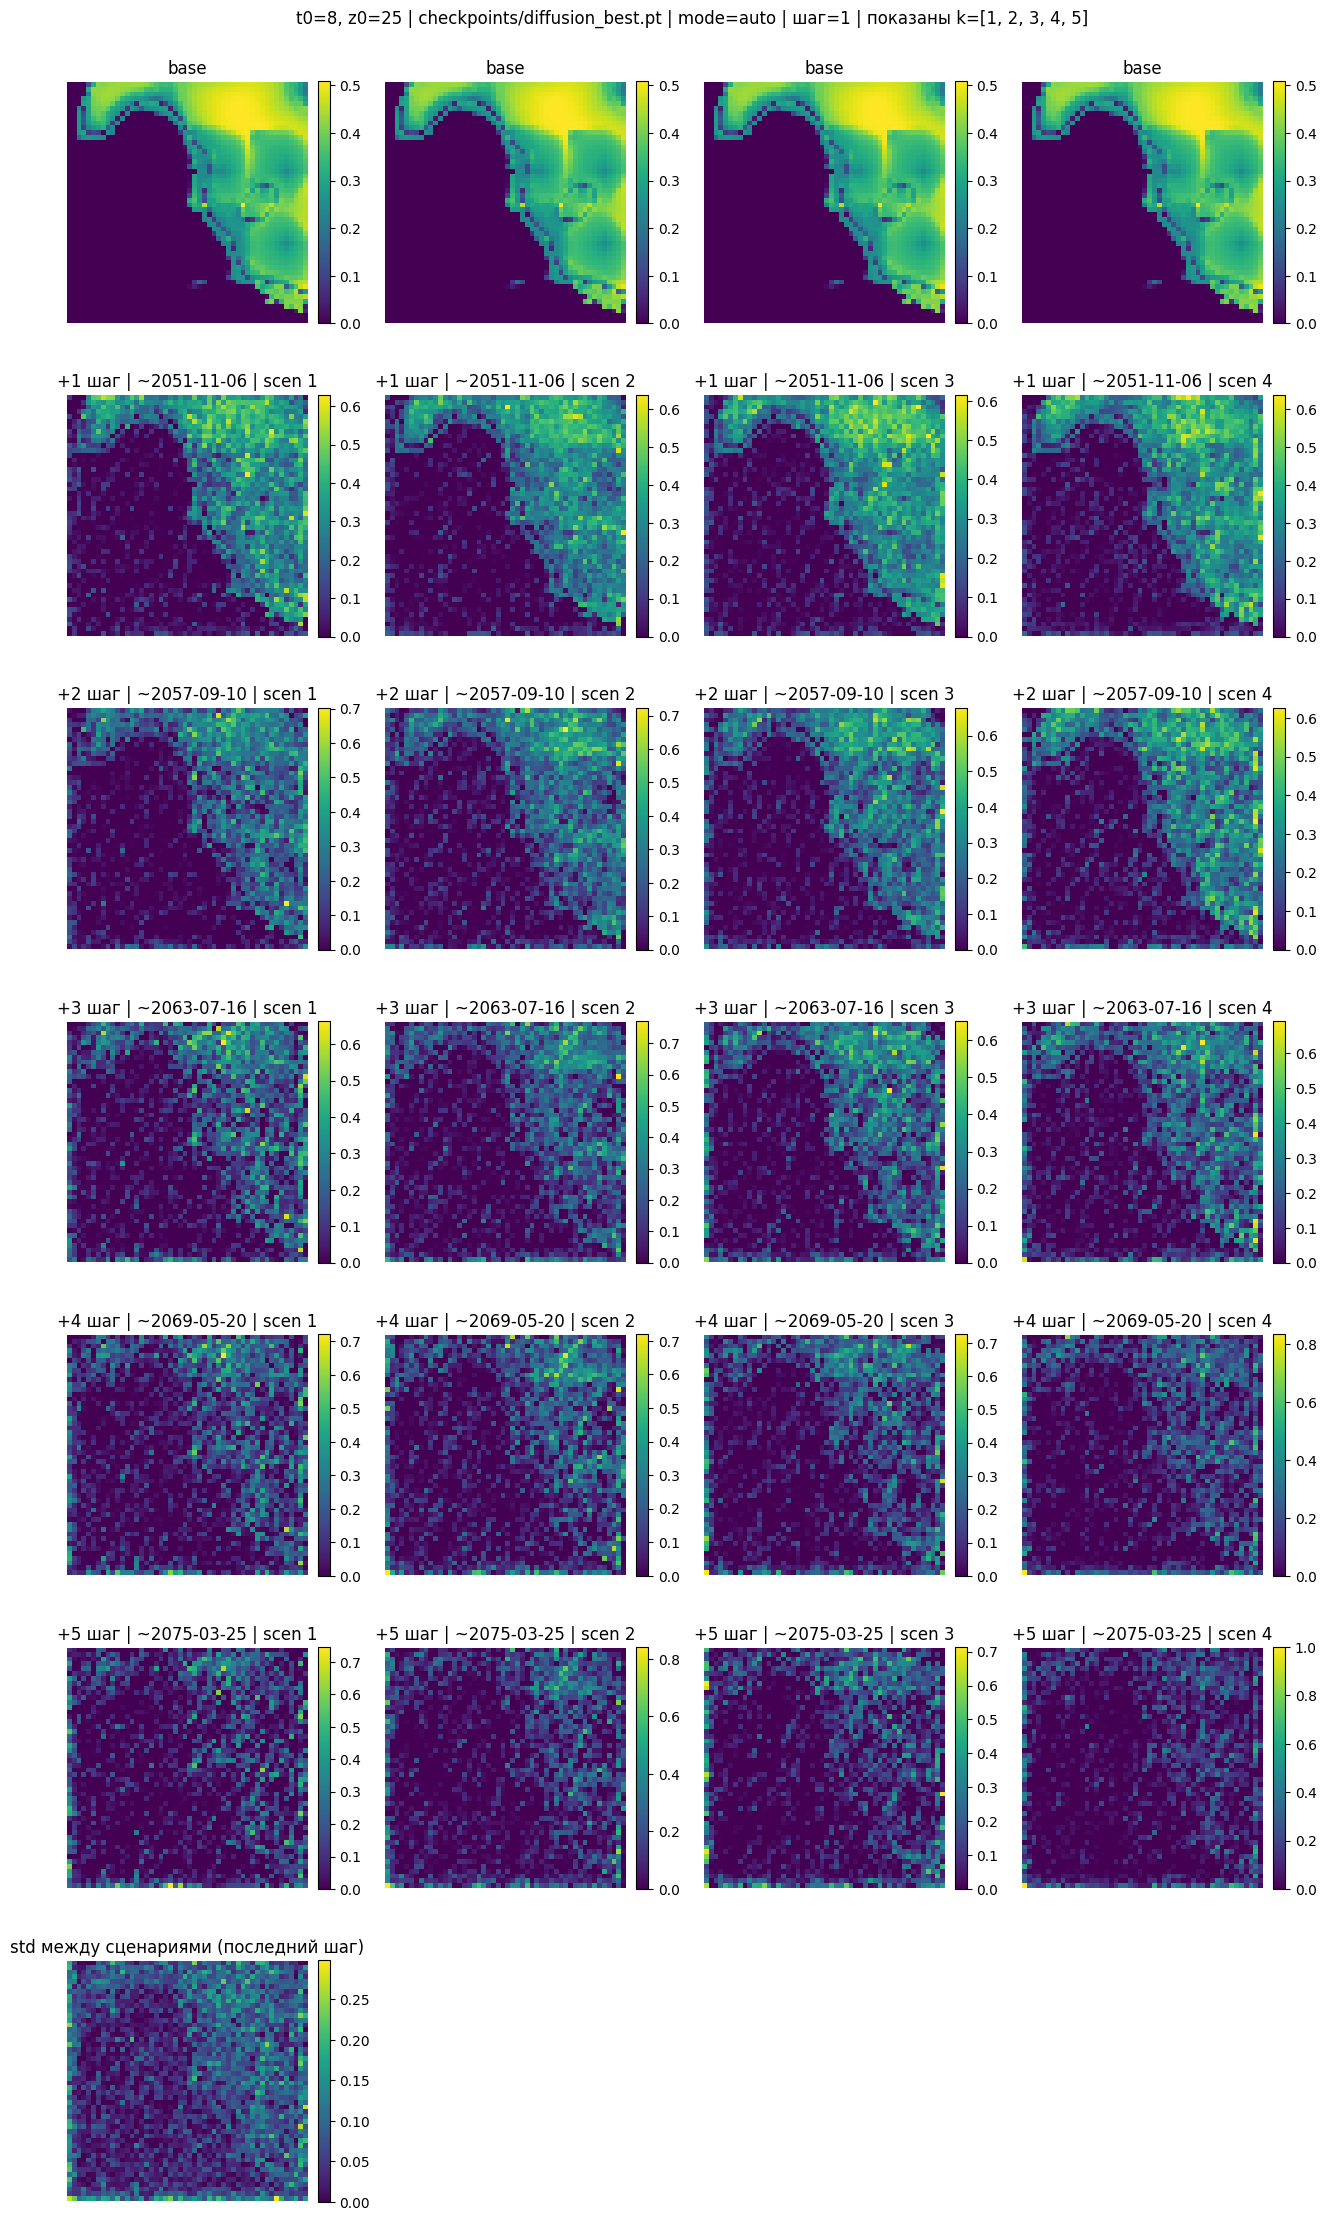

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from datetime import datetime, timedelta

# ---------- helpers for date labels ----------
def _parse_dates(date_strings):
    dates = []
    for s in date_strings:
        try:
            dates.append(datetime.strptime(str(s), "%Y-%m-%d"))
        except Exception:
            dates.append(None)
    return dates

def _mean_step_days(dates):
    good = [d for d in dates if d is not None]
    if len(good) < 2:
        return None
    diffs = []
    for i in range(len(good)-1):
        diffs.append((good[i+1] - good[i]).days)
    return float(np.mean(diffs)) if diffs else None

def _build_k_schedule(maps_count, horizon_steps=None):
    # какие горизонты показать (в индекс-шагах)
    if horizon_steps is None:
        return list(range(1, maps_count + 1))
    horizon_steps = int(max(1, horizon_steps))
    maps_count = int(max(1, maps_count))
    if maps_count == 1:
        return [horizon_steps]
    ks = np.linspace(1, horizon_steps, maps_count).round().astype(int).tolist()
    ks = [max(1, int(k)) for k in ks]
    # убираем дубликаты, но сохраняем порядок
    out = []
    for k in ks:
        if k not in out:
            out.append(k)
    return out

# ---------- visualization like v1 ----------
def visualize_rollout_grid_v1like(results, base_map, step_labels, title_prefix="", vmax01=True, max_scenarios=8):
    """
    results: list[scenario][step] -> (H,W) in 0..1
    base_map: (H,W)
    step_labels: list[str] length = steps
    """
    S = min(len(results), max_scenarios)
    steps = len(results[0]) if S else 0
    rows = 1 + steps + 1
    cols = S

    vmin, vmax = (0.0, 1.0) if vmax01 else (None, None)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.2), squeeze=False)
    fig.suptitle(title_prefix, y=0.995)

    # base row
    for c in range(cols):
        im = axes[0, c].imshow(base_map, origin="lower", vmin=vmin, vmax=vmax)
        axes[0, c].set_title("base")
        axes[0, c].axis("off")
        plt.colorbar(im, ax=axes[0, c], fraction=0.046, pad=0.04)

    # steps
    for i in range(steps):
        for s in range(cols):
            im = axes[i + 1, s].imshow(results[s][i], origin="lower", vmin=vmin, vmax=vmax)
            axes[i + 1, s].set_title(f"{step_labels[i]} | scen {s+1}")
            axes[i + 1, s].axis("off")
            plt.colorbar(im, ax=axes[i + 1, s], fraction=0.046, pad=0.04)

    # std last step
    last_maps = np.stack([results[s][-1] for s in range(cols)], axis=0)
    std_map = last_maps.std(axis=0)

    im = axes[-1, 0].imshow(std_map, origin="lower")
    axes[-1, 0].set_title("std между сценариями (последний шаг)")
    axes[-1, 0].axis("off")
    plt.colorbar(im, ax=axes[-1, 0], fraction=0.046, pad=0.04)
    for c in range(1, cols):
        axes[-1, c].axis("off")

    plt.tight_layout()
    plt.show()

@torch.no_grad()
def load_full_pipeline(ckpt_path: str, device: torch.device, *, layers: int | None = None, max_delta_steps: int | None = None):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = ckpt.get("config", config)

    # --- auto infer if not provided ---
    if max_delta_steps is None:
        max_delta_steps = int(cfg["data"]["max_delta_steps"])

    if layers is None:
        # если не записано в config, оставим 50 как дефолт (или потом передадим явно)
        layers = int(cfg["data"].get("layers", 50))

    latent_enabled = bool(ckpt.get("latent_enabled", cfg.get("latent", {}).get("enabled", False)))
    latent_ch = int(ckpt.get("latent_ch", cfg.get("latent", {}).get("latent_channels", 8)))

    delta_encoding = cfg["data"]["delta_encoding"]
    delta_freqs = int(cfg["data"]["delta_freqs"])
    z_encoding = cfg["data"]["z_encoding"]
    z_freqs = int(cfg["data"]["z_freqs"])

    dummy_delta = encode_scalar_channel(
        0.5,
        encoding=delta_encoding,
        n_freq=delta_freqs,
        onehot_size=int(max_delta_steps),
        onehot_kind="delta",
        max_delta_steps=int(max_delta_steps),
    )
    dummy_z = encode_scalar_channel(
        0.5,
        encoding=z_encoding,
        n_freq=z_freqs,
        onehot_size=int(layers),
        onehot_kind="z",
    )

    cond_channels = 1 + (latent_ch if latent_enabled else 1) + int(dummy_delta.shape[0]) + int(dummy_z.shape[0])
    target_channels = latent_ch if latent_enabled else 1

    unet = SimpleUNet(
        target_channels=target_channels,
        cond_channels=cond_channels,
        base_channels=int(cfg["model"]["base_channels"]),
    ).to(device)

    diffusion = GaussianDiffusionV2(
        model=unet,
        timesteps=int(cfg["diffusion"]["timesteps"]),
        beta_start=float(cfg["diffusion"]["beta_start"]),
        beta_end=float(cfg["diffusion"]["beta_end"]),
    ).to(device)

    diffusion.load_state_dict(ckpt["diffusion"], strict=True)
    diffusion.eval()

    if "ema_shadow" in ckpt:
        ema = EMA(diffusion.model, decay=float(cfg["train"].get("ema_decay", 0.999)))
        ema.shadow = {k: v.to(device) for k, v in ckpt["ema_shadow"].items()}
        ema.apply_to(diffusion.model)
        print("[load] EMA applied")

    if latent_enabled:
        vae = VAE2D(in_ch=1, latent_ch=latent_ch, hidden=64).to(device)
        if "vae" in ckpt:
            vae.load_state_dict(ckpt["vae"], strict=False)
        vae.eval()
    else:
        vae = None

    dS_clip = float(ckpt.get("dS_clip", cfg["data"].get("dS_clip", 0.1)))
    return diffusion, vae, dS_clip, cfg

# ---------- rollout like v1 ----------
@torch.no_grad()
def rollout_scenarios_full_v1like(
    *,
    data_path: str,
    ckpt_path: str,
    start_t: int,
    start_z: int,
    scenarios_count: int,
    maps_count: int,
    forecast_mode: str = "auto",   # "auto" or "from_base"
    horizon_steps: int | None = None,   # для delta_mode="index": на сколько индексов вперёд
    horizon_years: float | None = None, # опционально: конвертировать в horizon_steps по средней частоте дат
    max_scenarios_show: int = 8,
):
    device = resolve_device(config["train"].get("device"), None)
    diffusion, vae, dS_clip, cfg = load_full_pipeline(ckpt_path, device=device)

    data = np.load(data_path)
    sat_raw = data["saturations"].astype(np.float32)      # (T,Z,H,W)
    actnum = data["actnum_mask"].astype(bool)             # (Z,H,W)
    date_strings = data.get("date_strings", None)

    T, Z, H, W = sat_raw.shape
    start_t = int(np.clip(start_t, 0, T-1))
    start_z = int(np.clip(start_z, 0, Z-1))

    # базовая карта и маска
    base01 = np.nan_to_num(sat_raw[start_t, start_z], nan=0.0).astype(np.float32)
    base_ok = np.isfinite(sat_raw[start_t, start_z])
    mask2d = (actnum[start_z] & base_ok).astype(np.float32)

    # что было при обучении
    target_mode = str(cfg["task"]["target_mode"])
    delta_mode = str(cfg["data"]["delta_mode"])
    max_delta_steps = int(cfg["data"]["max_delta_steps"])
    delta_encoding = str(cfg["data"]["delta_encoding"])
    delta_freqs = int(cfg["data"]["delta_freqs"])
    z_encoding = str(cfg["data"]["z_encoding"])
    z_freqs = int(cfg["data"]["z_freqs"])

    sampler = str(cfg.get("sampling", {}).get("sampler", "ddpm"))
    eta = float(cfg.get("sampling", {}).get("ddim_eta", 0.0))
    clip_denoised = bool(cfg.get("sampling", {}).get("clip_denoised", True))
    clip_range = (-1.0, 1.0)

    # z_norm как в датасете
    z_norm = float(start_z) / float(max(1, Z - 1))

    # ---------- выбрать горизонты ----------
    if delta_mode != "index":
        raise ValueError("Эта v1-like визуализация сейчас заточена под delta_mode='index' (как у тебя в первой версии).")

    # если задан horizon_years — переведём в horizon_steps по среднему шагу дат
    if horizon_years is not None and date_strings is not None:
        dates = _parse_dates(date_strings)
        msd = _mean_step_days(dates)
        if msd is not None and msd > 0:
            steps_per_year = 365.25 / msd
            horizon_steps = int(round(float(horizon_years) * steps_per_year))

    k_list = _build_k_schedule(maps_count=maps_count, horizon_steps=horizon_steps)

    # onehot не умеет k>max_delta_steps
    if delta_encoding == "onehot":
        k_list = [min(int(k), max_delta_steps) for k in k_list]

    # подписи по времени/шагу
    step_labels = []
    if date_strings is not None:
        dates = _parse_dates(date_strings)
        msd = _mean_step_days(dates)
    else:
        dates, msd = None, None

    for k in k_list:
        t2 = start_t + int(k)
        if dates is not None and t2 < len(dates) and dates[start_t] is not None and dates[t2] is not None:
            step_labels.append(f"+{k} шаг | {dates[t2].strftime('%Y-%m-%d')}")
        elif dates is not None and dates[start_t] is not None and msd is not None:
            approx = dates[start_t] + timedelta(days=msd * float(k))
            step_labels.append(f"+{k} шаг | ~{approx.strftime('%Y-%m-%d')}")
        else:
            step_labels.append(f"+{k} шаг")

    # ---------- sampling core ----------
    def _sample_next(cur01, delta_norm):
        # собрать batch (B=1)
        base_n = norm_state01_to_n11(cur01)[None, None]  # (1,1,H,W) in [-1,1]
        mask_t = torch.from_numpy(mask2d)[None, None].to(device)

        batch = {
            "mask": mask_t,
            "base": torch.from_numpy(base_n.astype(np.float32)).to(device),
            "delta_norm": torch.tensor([float(delta_norm)], dtype=torch.float32).to(device),
            "z_norm": torch.tensor([float(z_norm)], dtype=torch.float32).to(device),
        }

        if vae is not None:
            base_lat = vae_encode_mean(vae, batch["base"])
            cond = build_cond_from_batch(batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=base_lat)
            out_lat = diffusion.sample(cond, sampler=sampler, ddim_eta=eta, clip_denoised=clip_denoised, clip_range=clip_range)
            out_n = vae.decode(out_lat).detach().cpu().numpy()[0, 0]
        else:
            cond = build_cond_from_batch(batch, device, delta_encoding, delta_freqs, z_encoding, z_freqs, base_latent=None)
            out = diffusion.sample(cond, sampler=sampler, ddim_eta=eta, clip_denoised=clip_denoised, clip_range=clip_range)
            out_n = out.detach().cpu().numpy()[0, 0]

        # перевести в nxt01
        if target_mode == "state":
            nxt01 = denorm_state_n11_to_01(out_n)
        else:
            dS = (out_n * float(dS_clip)).astype(np.float32)
            nxt01 = np.clip(cur01 + dS, 0.0, 1.0).astype(np.float32)

        # обновлять только активное
        nxt01 = nxt01 * mask2d + cur01 * (1.0 - mask2d)
        return nxt01

    # ---------- rollout ----------
    S = int(scenarios_count)
    results = []

    if forecast_mode == "auto":
        # autoregressive шагом k=1, а сохраняем на k из k_list
        max_k = int(max(k_list))
        delta_norm_step = 1.0 / float(max(1, max_delta_steps))

        for s in range(S):
            torch.manual_seed(int(cfg.get("inference", {}).get("seed0", 1234)) + s)
            cur = base01.copy()
            scen = []
            saved = {int(k): None for k in k_list}

            for step in range(1, max_k + 1):
                cur = _sample_next(cur, delta_norm_step)
                if step in saved:
                    scen.append(cur.copy())

            # если вдруг k_list не строго 1..max_k без дыр — scen уже в порядке k_list
            results.append(scen)

        meta = f"t0={start_t}, z0={start_z} | {ckpt_path} | mode=auto | шаг=1 | показаны k={k_list}"

    elif forecast_mode == "from_base":
        # каждый горизонт k считаем напрямую от базы
        for s in range(S):
            torch.manual_seed(int(cfg.get("inference", {}).get("seed0", 1234)) + s)
            scen = []
            for k in k_list:
                delta_norm = float(k) / float(max(1, max_delta_steps))
                pred = _sample_next(base01.copy(), delta_norm)
                scen.append(pred.copy())
            results.append(scen)

        meta = f"t0={start_t}, z0={start_z} | {ckpt_path} | mode=from_base | показаны k={k_list}"

    else:
        raise ValueError("forecast_mode должен быть 'auto' или 'from_base'.")

    return results, base01, step_labels, meta

scenarios_count = 4
maps_count = 5

# как в первой версии: последний t и средний z
data_tmp = np.load("gdm_saturation.npz")
T, Z, H, W = data_tmp["saturations"].shape
data_tmp.close()

start_t = T - 1
start_z = Z // 2


# что именно ты хочешь:
forecast_mode = "auto"      # "auto" = роллаут во времени шагом 1
# forecast_mode = "from_base"  # каждый прогноз от базы на горизонты k

# горизонт и частота:
horizon_steps = 5
horizon_years = None  # или, например, 10.0 (сам переведёт в шаги по датам)

results, base_map, labels, meta = rollout_scenarios_full_v1like(
    data_path="gdm_saturation.npz",
    ckpt_path="checkpoints/diffusion_best.pt",
    start_t=start_t,
    start_z=start_z,
    scenarios_count=scenarios_count,
    maps_count=maps_count,
    forecast_mode=forecast_mode,
    horizon_steps=horizon_steps,
    horizon_years=horizon_years,
)

visualize_rollout_grid_v1like(
    results, base_map, labels,
    title_prefix=meta,
    vmax01=False,
    max_scenarios=8
)
